# MEAT CONSUMPTION

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)
import numpy as np
import warnings
from itertools import product
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import skew
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

warnings.simplefilter("ignore", ConvergenceWarning)


In [2]:
# Load the dataset
dMeat = pd.read_csv(r"C:\Users\Ahmad1\Documents\GitHub\ie423-2024-termproject-the-a-team\DataSets\MeatConsumption\meat_consumption_worldwide.csv")

In [3]:
# Display the first few rows of the dataset
print(dMeat.head())
# Display information about the columns and data types
print(dMeat.info())

  LOCATION SUBJECT MEASURE  TIME      Value
0      AUS    BEEF  KG_CAP  1991  27.721815
1      AUS    BEEF  KG_CAP  1992  26.199591
2      AUS    BEEF  KG_CAP  1993  26.169094
3      AUS    BEEF  KG_CAP  1994  25.456134
4      AUS    BEEF  KG_CAP  1995  25.340226
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13760 entries, 0 to 13759
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LOCATION  13760 non-null  object 
 1   SUBJECT   13760 non-null  object 
 2   MEASURE   13760 non-null  object 
 3   TIME      13760 non-null  int64  
 4   Value     13760 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 537.6+ KB
None


In [4]:
# Create a mask for the specific locations you want to filter
specific_locations = ['WLD', 'OECD', 'BRICS', 'EU28']
mask_specific = dMeat['LOCATION'].isin(specific_locations)

# Create two separate DataFrames based on the mask
dMeat1 = dMeat[~mask_specific]  # DataFrame for all countries
dMeat2 = dMeat[mask_specific]   # DataFrame for specific locations

# Example of how to access these DataFrames
print("DataFrame dMeat1 (all countries):")
print(dMeat1.head())

print("\nDataFrame dMeat2 (specific locations 'WLD', 'OECD', 'BRICS', 'EU28'):")
print(dMeat2.head())

DataFrame dMeat1 (all countries):
  LOCATION SUBJECT MEASURE  TIME      Value
0      AUS    BEEF  KG_CAP  1991  27.721815
1      AUS    BEEF  KG_CAP  1992  26.199591
2      AUS    BEEF  KG_CAP  1993  26.169094
3      AUS    BEEF  KG_CAP  1994  25.456134
4      AUS    BEEF  KG_CAP  1995  25.340226

DataFrame dMeat2 (specific locations 'WLD', 'OECD', 'BRICS', 'EU28'):
     LOCATION SUBJECT MEASURE  TIME     Value
6025      WLD    BEEF  KG_CAP  2000  6.809180
6026      WLD    BEEF  KG_CAP  2001  6.589146
6027      WLD    BEEF  KG_CAP  2002  6.775302
6028      WLD    BEEF  KG_CAP  2003  6.603025
6029      WLD    BEEF  KG_CAP  2004  6.675570


## Check for missing values

In [5]:
# Check for missing values in dMeat1
print("Missing values in dMeat1:")
print(dMeat1.isnull().sum())

# Check for missing values in dMeat2
print("\nMissing values in dMeat2:")
print(dMeat2.isnull().sum())

Missing values in dMeat1:
LOCATION    0
SUBJECT     0
MEASURE     0
TIME        0
Value       0
dtype: int64

Missing values in dMeat2:
LOCATION    0
SUBJECT     0
MEASURE     0
TIME        0
Value       0
dtype: int64


No missing values in both datasets

In [6]:
# Check for duplicates in dMeat1
print("\nDuplicate rows in dMeat1:", dMeat1.duplicated().sum())

# Check for duplicates in dMeat2
print("Duplicate rows in dMeat2:", dMeat2.duplicated().sum())


Duplicate rows in dMeat1: 0
Duplicate rows in dMeat2: 0


No duplicate values in both datasets

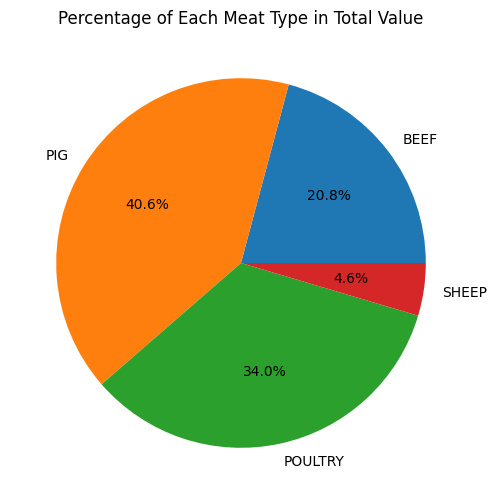

In [7]:
# Percentage of each type of Meat
total_value = dMeat['Value'].sum()
meat_percentages = (dMeat.groupby('SUBJECT')['Value'].sum() / total_value) * 100

plt.figure(figsize=(8, 6))
plt.pie(meat_percentages, labels=meat_percentages.index, autopct="%1.1f%%")
plt.title("Percentage of Each Meat Type in Total Value")
plt.show()


The pie chart shows the percentage of each meat type in total value. Pork makes up the largest portion of the chart at 40.6%.  Poultry comes in second at 34%, followed by beef at 20.8%, and sheep at 4.6%.

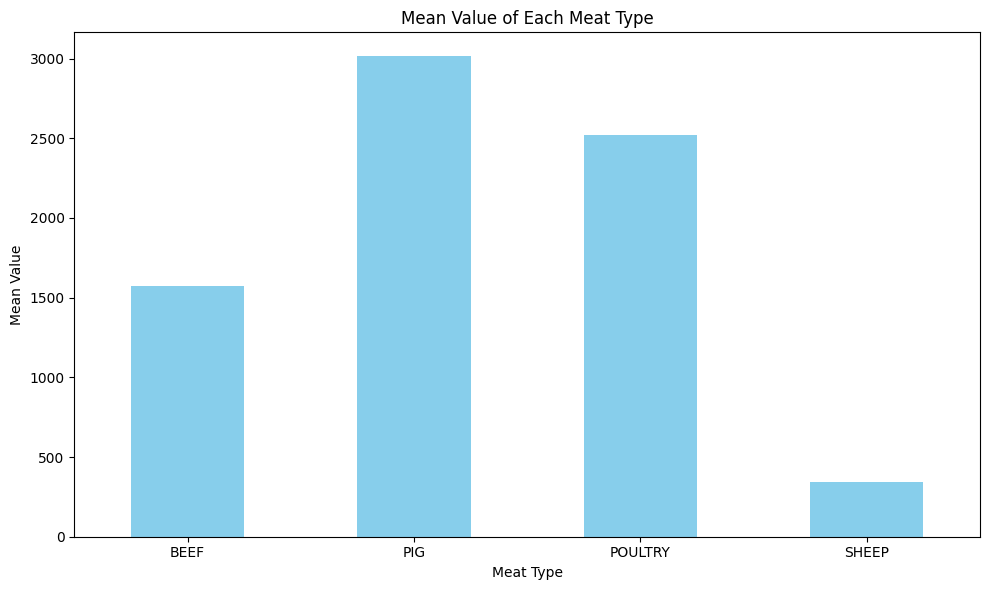

In [8]:
# Mean value for different types of Meat
mean_values = dMeat.groupby('SUBJECT')['Value'].mean()

plt.figure(figsize=(10, 6))
mean_values.plot(kind='bar', color='skyblue')
plt.xlabel("Meat Type")
plt.ylabel("Mean Value")
plt.title("Mean Value of Each Meat Type")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

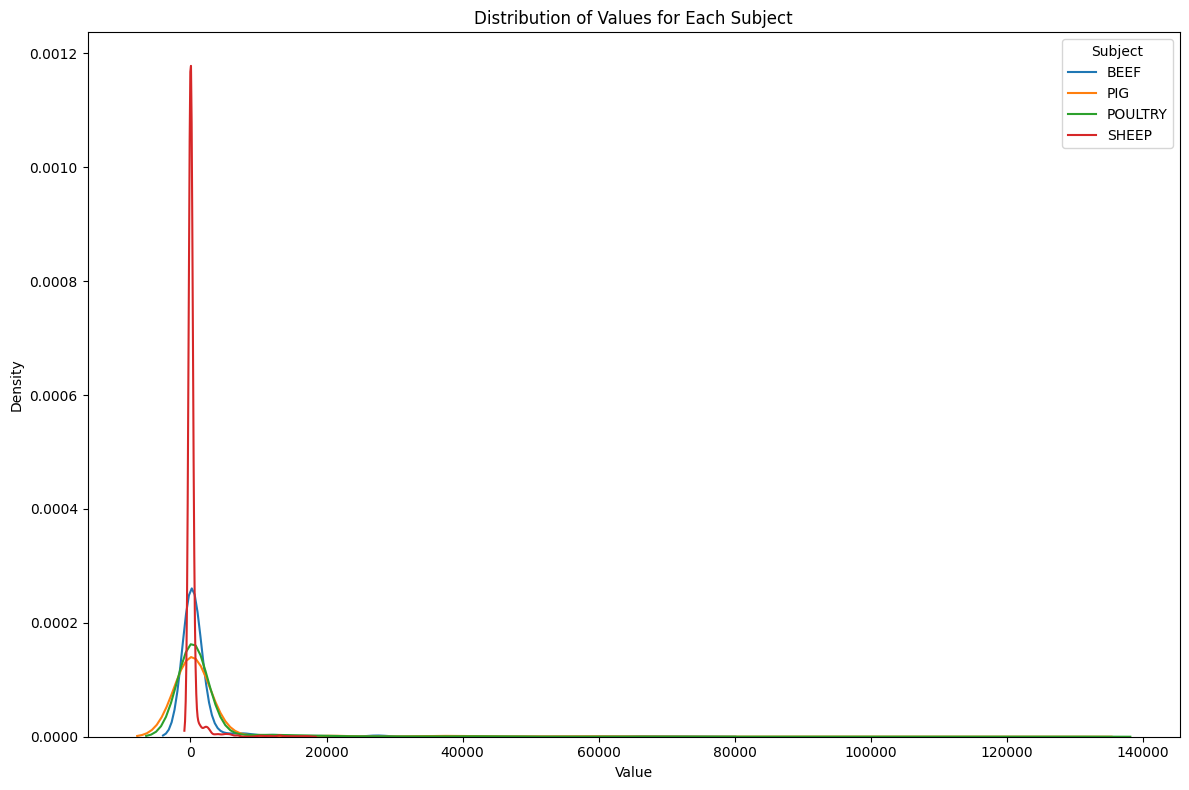

In [9]:

# Distribution of values for each subject
plt.figure(figsize=(12, 8))

for subject in dMeat['SUBJECT'].unique():
    subject_data = dMeat[dMeat['SUBJECT'] == subject]
    sns.kdeplot(subject_data['Value'], label=subject)

plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Distribution of Values for Each Subject")
plt.legend(title="Subject")
plt.tight_layout()
plt.show()

There seems to be more data points towards the lower end of the value range for each subject. This suggests that the values are skewed towards the left.

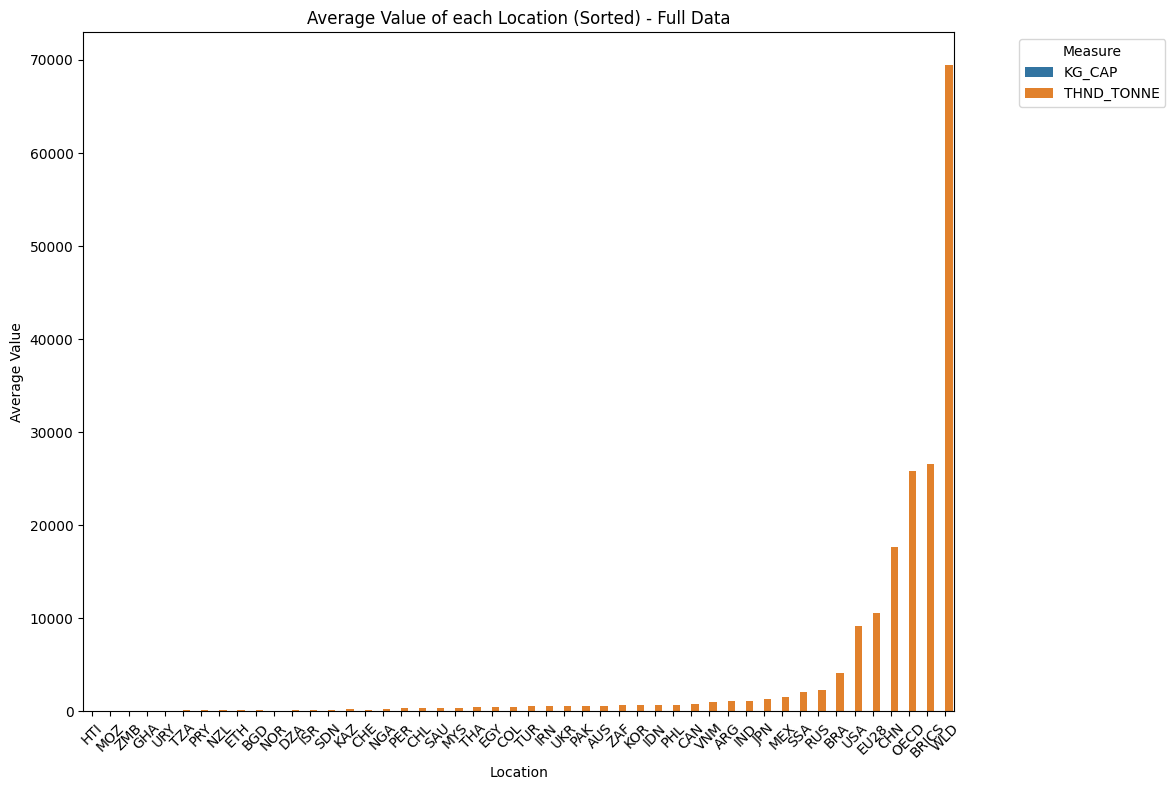

In [10]:
# Function to plot average value by location
def plot_average_value_by_location(dataset, dataset_name):
    average_values = dataset.groupby('LOCATION')['Value'].mean().reset_index()
    sorted_locations = average_values.sort_values(by='Value')
    
    plt.figure(figsize=(12, 8))
    if 'MEASURE' in dataset.columns:
        sns.barplot(data=dataset, x='LOCATION', y='Value', hue='MEASURE', errorbar=None, order=sorted_locations['LOCATION'])
    else:
        sns.barplot(data=dataset, x='LOCATION', y='Value', errorbar=None, order=sorted_locations['LOCATION'])
        
    plt.title(f'Average Value of each Location (Sorted) - {dataset_name}')
    plt.xlabel('Location')
    plt.ylabel('Average Value')
    plt.xticks(rotation=45)
    if 'MEASURE' in dataset.columns:
        plt.legend(title='Measure', loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.tight_layout()
    plt.show()

plot_average_value_by_location(dMeat, "Full Data")

## Checking outliers

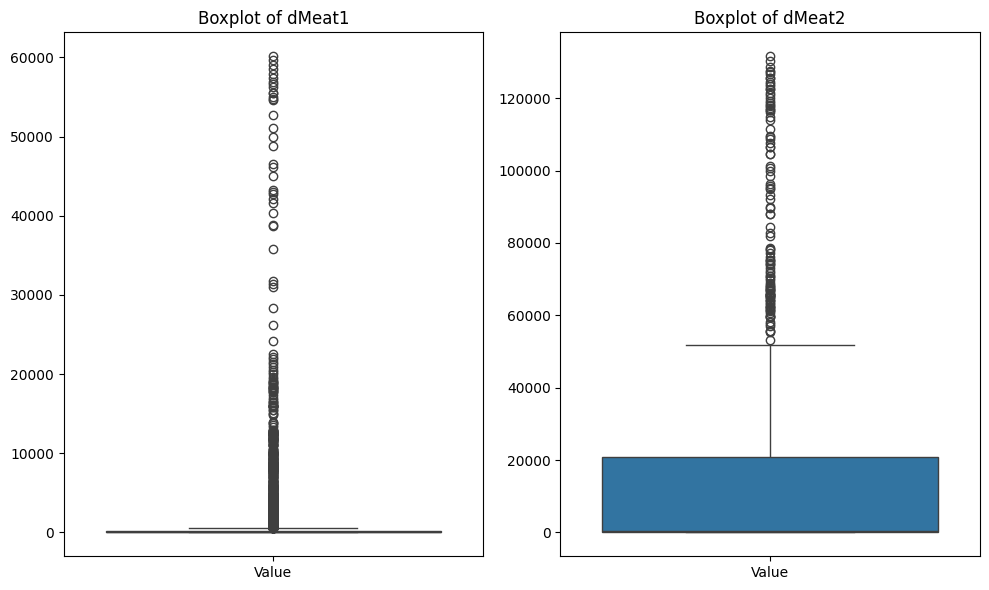

In [11]:
# Select numerical columns for outlier detection (assuming 'Value' column is numerical)
numerical_cols = ['Value']

# Visualize boxplots to identify outliers
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=dMeat1[numerical_cols])
plt.title('Boxplot of dMeat1')

plt.subplot(1, 2, 2)
sns.boxplot(data=dMeat2[numerical_cols])
plt.title('Boxplot of dMeat2')

plt.tight_layout()
plt.show()

In [12]:
# Function to detect outliers using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Assuming 'Value' is the numerical column to check for outliers
outliers_dMeat1 = detect_outliers(dMeat1, 'Value')
outliers_dMeat2 = detect_outliers(dMeat2, 'Value')

# Display outliers found
print("Outliers in dMeat1:")
print(outliers_dMeat1)

print("\nOutliers in dMeat2:")
print(outliers_dMeat2)

Outliers in dMeat1:
      LOCATION  SUBJECT     MEASURE  TIME        Value
6793       KOR      PIG  THND_TONNE  1992   748.999928
6794       KOR      PIG  THND_TONNE  1993   761.999935
6795       KOR      PIG  THND_TONNE  1994   794.999893
6796       KOR      PIG  THND_TONNE  1995   834.999896
6797       KOR      PIG  THND_TONNE  1996   900.999940
...        ...      ...         ...   ...          ...
13683      KOR  POULTRY  THND_TONNE  2022  1018.578616
13684      KOR  POULTRY  THND_TONNE  2023  1028.615915
13685      KOR  POULTRY  THND_TONNE  2024  1039.824445
13686      KOR  POULTRY  THND_TONNE  2025  1050.436219
13687      KOR  POULTRY  THND_TONNE  2026  1060.382902

[2028 rows x 5 columns]

Outliers in dMeat2:
      LOCATION  SUBJECT     MEASURE  TIME          Value
11689      WLD      PIG  THND_TONNE  1993   74906.787088
11690      WLD      PIG  THND_TONNE  1994   78044.512121
11691      WLD      PIG  THND_TONNE  1995   78705.389054
11692      WLD      PIG  THND_TONNE  1996   78

In [13]:
# Drop outliers from dMeat2
dMeat2_no_outliers = dMeat2[~dMeat2.index.isin(outliers_dMeat2.index)]

# Confirm the shape after dropping outliers
print("\nShape of dMeat2 after dropping outliers:", dMeat2_no_outliers.shape)


Shape of dMeat2 after dropping outliers: (978, 5)


In [14]:
# Function to perform label encoding for categorical columns
def label_encode_columns(df, columns):
    label_encoder = LabelEncoder()
    for col in columns:
        if col in df.columns:
            df.loc[:, col + '_encoded'] = label_encoder.fit_transform(df[col])
    return df

# List of categorical columns to be encoded
categorical_columns = ['LOCATION', 'SUBJECT', 'MEASURE']

# Apply label encoding to dMeat1
dMeat1_encoded = label_encode_columns(dMeat1, categorical_columns)

# Apply label encoding to dMeat2
dMeat2_encoded = label_encode_columns(dMeat2, categorical_columns)

# Display encoded dataframes or further process as needed
print("dMeat1 after label encoding:")
print(dMeat1_encoded.head())

print("\ndMeat2 after label encoding:")
print(dMeat2_encoded.head())

dMeat1 after label encoding:
  LOCATION SUBJECT MEASURE  TIME      Value  LOCATION_encoded  \
0      AUS    BEEF  KG_CAP  1991  27.721815                 1   
1      AUS    BEEF  KG_CAP  1992  26.199591                 1   
2      AUS    BEEF  KG_CAP  1993  26.169094                 1   
3      AUS    BEEF  KG_CAP  1994  25.456134                 1   
4      AUS    BEEF  KG_CAP  1995  25.340226                 1   

   SUBJECT_encoded  MEASURE_encoded  
0                0                0  
1                0                0  
2                0                0  
3                0                0  
4                0                0  

dMeat2 after label encoding:
     LOCATION SUBJECT MEASURE  TIME     Value  LOCATION_encoded  \
6025      WLD    BEEF  KG_CAP  2000  6.809180                 3   
6026      WLD    BEEF  KG_CAP  2001  6.589146                 3   
6027      WLD    BEEF  KG_CAP  2002  6.775302                 3   
6028      WLD    BEEF  KG_CAP  2003  6.603025         

C:\Users\Ahmad1\AppData\Local\Temp\ipykernel_19672\2978148625.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col + '_encoded'] = label_encoder.fit_transform(df[col])
C:\Users\Ahmad1\AppData\Local\Temp\ipykernel_19672\2978148625.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col + '_encoded'] = label_encoder.fit_transform(df[col])
C:\Users\Ahmad1\AppData\Local\Temp\ipykernel_19672\2978148625.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

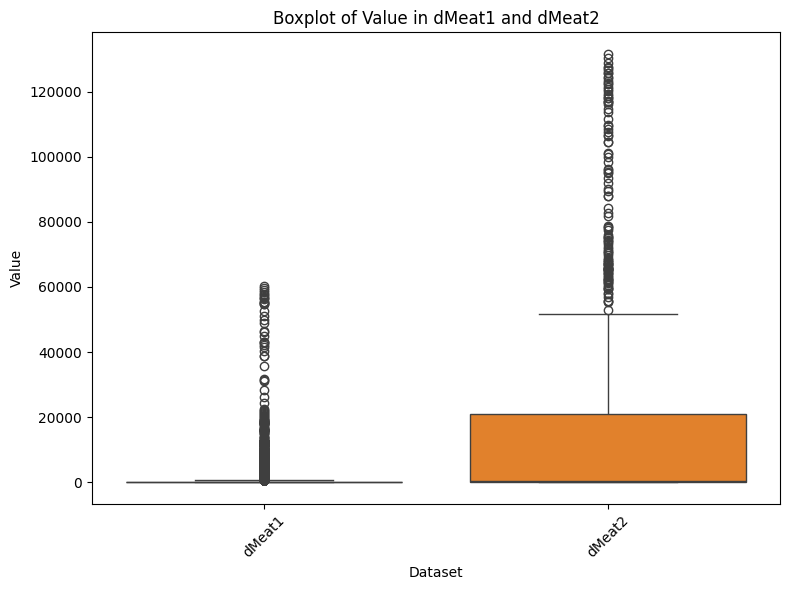

Outliers in dMeat1_encoded:
      LOCATION  SUBJECT     MEASURE  TIME        Value  LOCATION_encoded  \
6793       KOR      PIG  THND_TONNE  1992   748.999928                20   
6794       KOR      PIG  THND_TONNE  1993   761.999935                20   
6795       KOR      PIG  THND_TONNE  1994   794.999893                20   
6796       KOR      PIG  THND_TONNE  1995   834.999896                20   
6797       KOR      PIG  THND_TONNE  1996   900.999940                20   
...        ...      ...         ...   ...          ...               ...   
13683      KOR  POULTRY  THND_TONNE  2022  1018.578616                20   
13684      KOR  POULTRY  THND_TONNE  2023  1028.615915                20   
13685      KOR  POULTRY  THND_TONNE  2024  1039.824445                20   
13686      KOR  POULTRY  THND_TONNE  2025  1050.436219                20   
13687      KOR  POULTRY  THND_TONNE  2026  1060.382902                20   

       SUBJECT_encoded  MEASURE_encoded  
6793             

In [15]:
# Assuming the following column names after label encoding
# Replace these with the actual column names after your label encoding step
dMeat1_numerical_col = 'Value'  # Replace with your actual column name
dMeat2_numerical_col = 'Value'  # Replace with your actual column name

# Combine dMeat1_encoded and dMeat2_encoded for visualization
combined_data = pd.concat([dMeat1_encoded[[dMeat1_numerical_col]], dMeat2_encoded[[dMeat2_numerical_col]]], axis=1)
combined_data.columns = ['dMeat1', 'dMeat2']

# Visualize boxplots to identify outliers
plt.figure(figsize=(8, 6))
sns.boxplot(data=combined_data)
plt.title('Boxplot of Value in dMeat1 and dMeat2')
plt.xlabel('Dataset')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Function to detect outliers using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Detect outliers in dMeat1_encoded and dMeat2_encoded
outliers_dMeat1 = detect_outliers(dMeat1_encoded, dMeat1_numerical_col)
outliers_dMeat2 = detect_outliers(dMeat2_encoded, dMeat2_numerical_col)

# Display outliers found
print("Outliers in dMeat1_encoded:")
print(outliers_dMeat1)

print("\nOutliers in dMeat2_encoded:")
print(outliers_dMeat2)


In [16]:
# Drop outliers from dMeat2
dMeat2_clean = dMeat2_encoded.drop(outliers_dMeat2.index)

# Confirm the shape after dropping outliers
print("Shape of dMeat2 after dropping outliers:", dMeat2_clean.shape)

# Example of the cleaned dMeat2 DataFrame
print(dMeat2_clean.head())

Shape of dMeat2 after dropping outliers: (978, 8)
     LOCATION SUBJECT MEASURE  TIME     Value  LOCATION_encoded  \
6025      WLD    BEEF  KG_CAP  2000  6.809180                 3   
6026      WLD    BEEF  KG_CAP  2001  6.589146                 3   
6027      WLD    BEEF  KG_CAP  2002  6.775302                 3   
6028      WLD    BEEF  KG_CAP  2003  6.603025                 3   
6029      WLD    BEEF  KG_CAP  2004  6.675570                 3   

      SUBJECT_encoded  MEASURE_encoded  
6025                0                0  
6026                0                0  
6027                0                0  
6028                0                0  
6029                0                0  


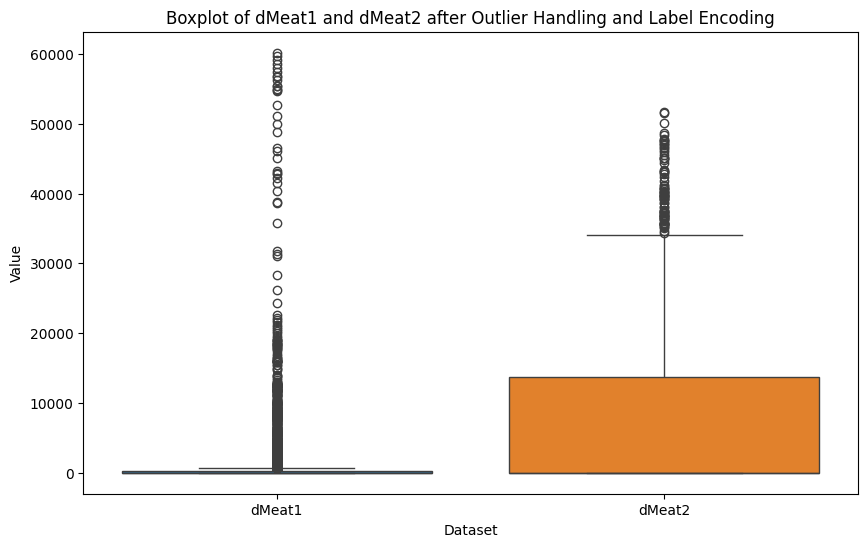

In [17]:
# Assuming 'Value' was encoded to 'Value_encoded' during preprocessing
# Adjust column names based on your actual DataFrame structure

# Combine dMeat1_encoded and dMeat2_clean for visualization
combined_data = pd.concat([dMeat1_encoded['Value'], dMeat2_clean['Value']], axis=1)
combined_data.columns = ['dMeat1', 'dMeat2']

# Visualize boxplots to identify outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data)
plt.title('Boxplot of dMeat1 and dMeat2 after Outlier Handling and Label Encoding')
plt.xlabel('Dataset')
plt.ylabel('Value')
plt.show()


In [18]:

# Assuming dMeat1 is your DataFrame
skewness = dMeat1['Value'].skew()
print(f"Skewness of 'Value' column in dMeat1: {skewness}")
# Assuming dMeat2 is your DataFrame
skewness = dMeat2_clean['Value'].skew()
print(f"Skewness of 'Value' column in dMeat1: {skewness}")


Skewness of 'Value' column in dMeat1: 12.632871506951988
Skewness of 'Value' column in dMeat1: 1.5388521800471273


C:\Users\Ahmad1\AppData\Local\Temp\ipykernel_19672\988812739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dMeat1_encoded['Value_log_transformed'] = np.log(dMeat1_encoded['Value'] + 1)  # Adding 1 to avoid log(0)


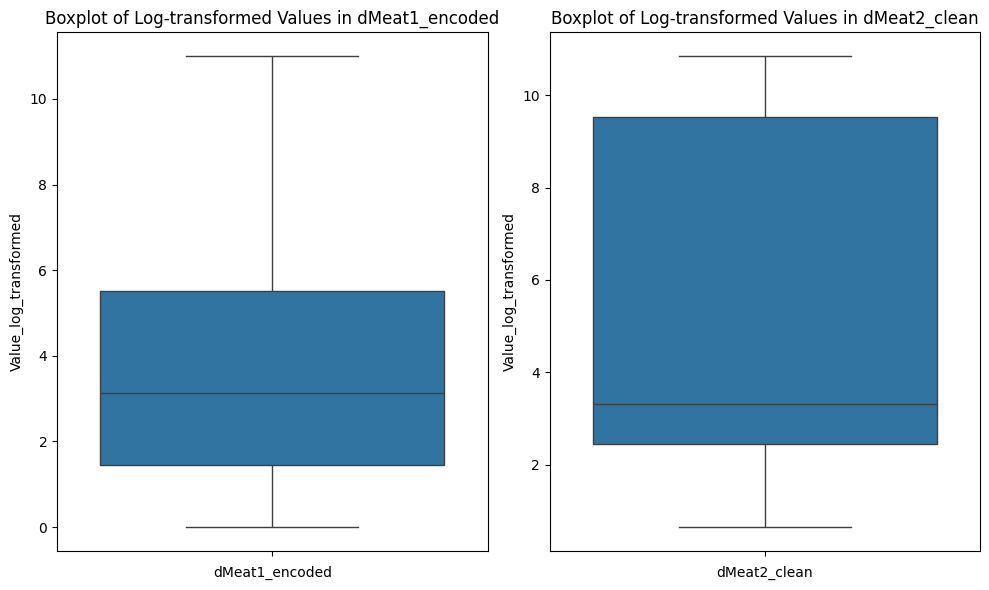

Skewness of 'Value_log_transformed' column in dMeat1_encoded: 0.42660534561413427
Skewness of 'Value_log_transformed' column in dMeat2_clean: 0.2397238292478285


In [19]:
# Ensure log transformation of the entire dataset
dMeat1_encoded['Value_log_transformed'] = np.log(dMeat1_encoded['Value'] + 1)  # Adding 1 to avoid log(0)
dMeat2_clean['Value_log_transformed'] = np.log(dMeat2_clean['Value'] + 1)  # Adding 1 to avoid log(0)

# Visualize boxplots for log-transformed 'Value' column in dMeat1_encoded and dMeat2_clean
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=dMeat1_encoded['Value_log_transformed'])
plt.title('Boxplot of Log-transformed Values in dMeat1_encoded')
plt.xlabel('dMeat1_encoded')

plt.subplot(1, 2, 2)
sns.boxplot(data=dMeat2_clean['Value_log_transformed'])
plt.title('Boxplot of Log-transformed Values in dMeat2_clean')
plt.xlabel('dMeat2_clean')

plt.tight_layout()
plt.show()

# Print skewness of log-transformed values
print("Skewness of 'Value_log_transformed' column in dMeat1_encoded:", skew(dMeat1_encoded['Value_log_transformed']))
print("Skewness of 'Value_log_transformed' column in dMeat2_clean:", skew(dMeat2_clean['Value_log_transformed']))


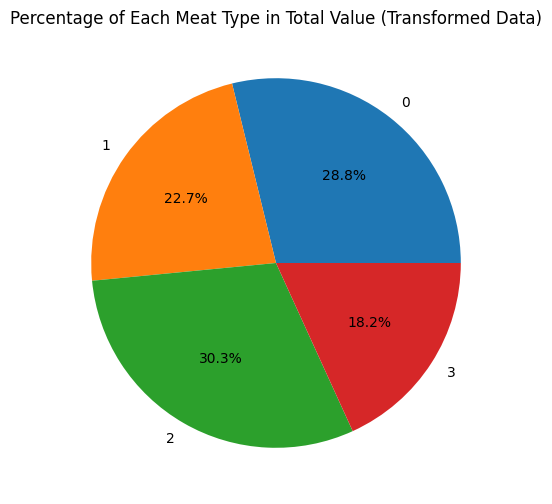

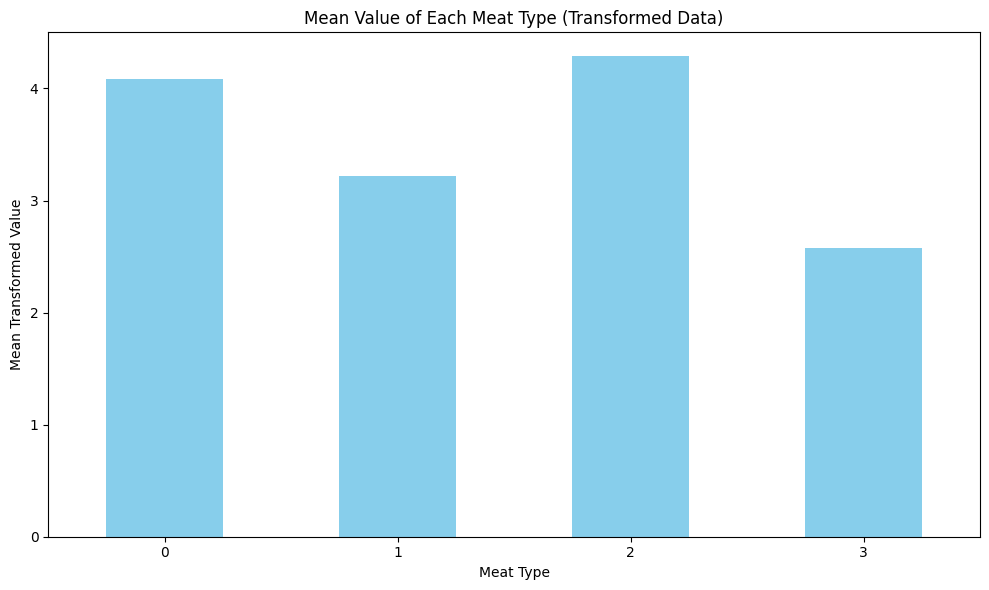

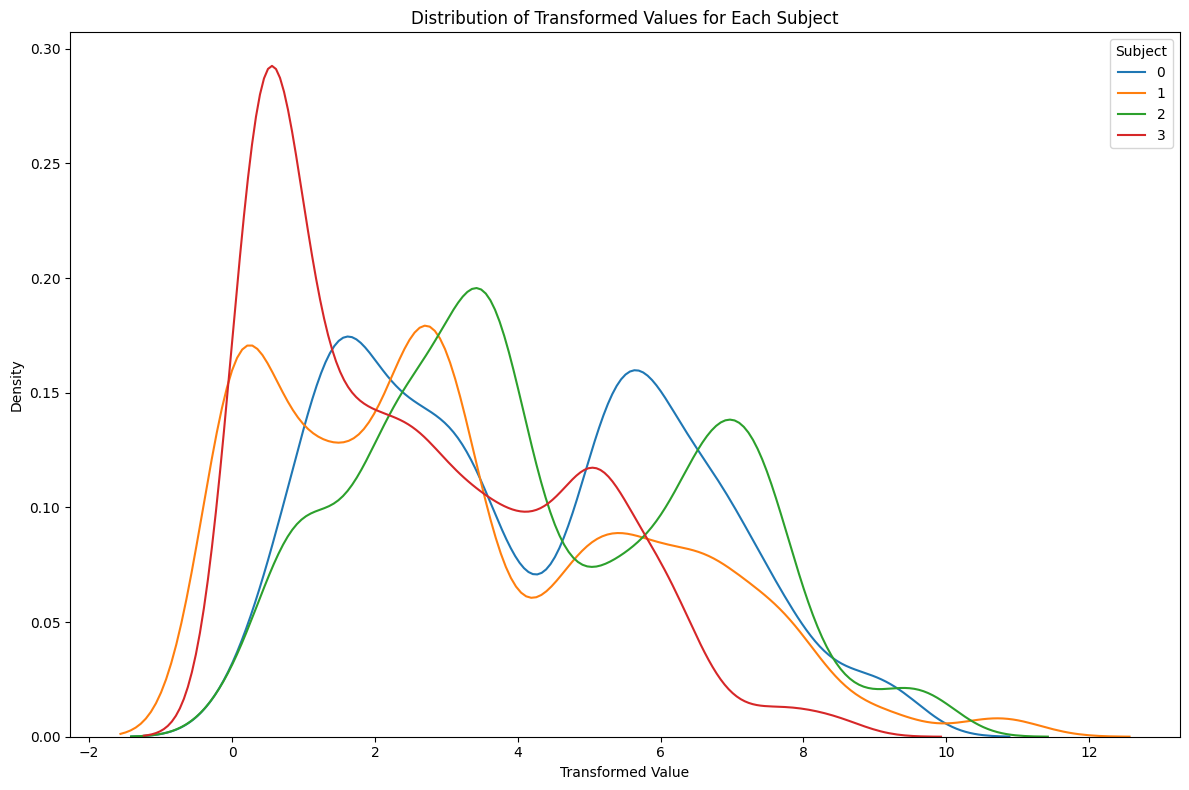

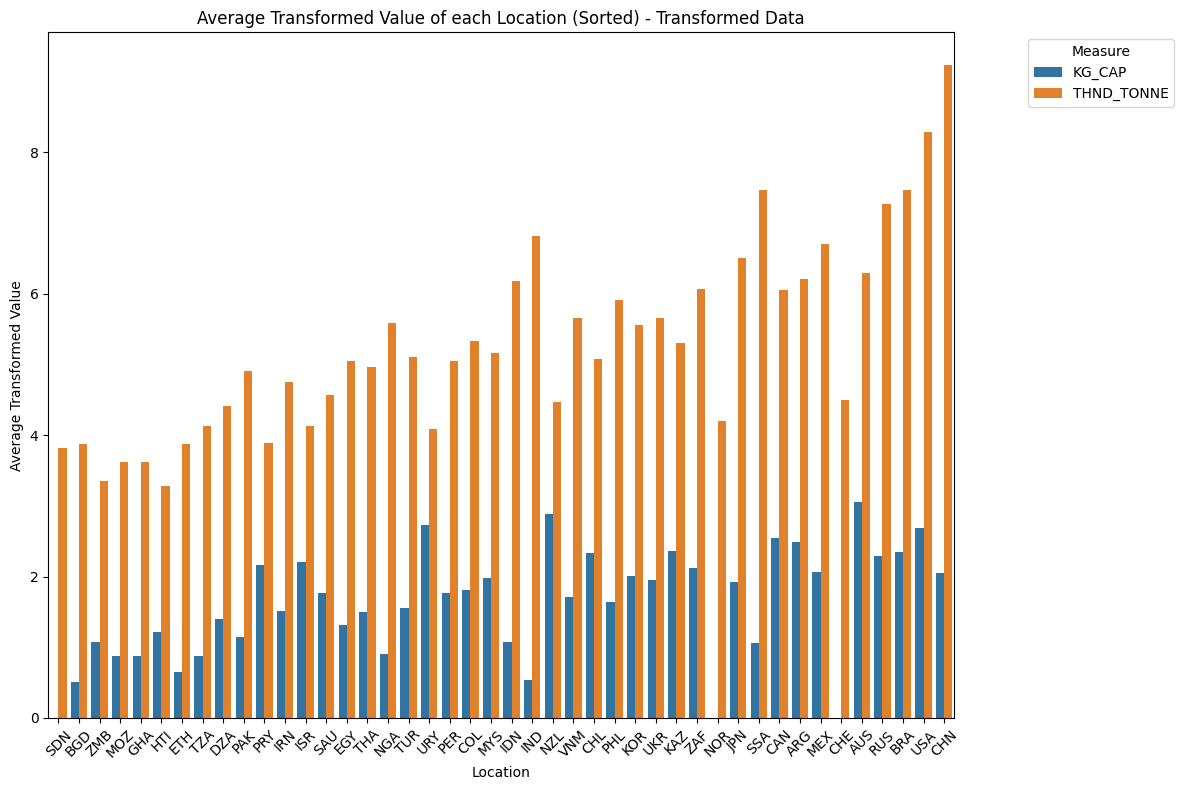

In [20]:
# Assuming dMeat1_encoded and dMeat2_clean are your transformed datasets

# Percentage of each type of Meat (After Cleaning and Transformation)
total_value_cleaned = dMeat1_encoded['Value_log_transformed'].sum()
meat_percentages_cleaned = (dMeat1_encoded.groupby('SUBJECT_encoded')['Value_log_transformed'].sum() / total_value_cleaned) * 100

plt.figure(figsize=(8, 6))
plt.pie(meat_percentages_cleaned, labels=meat_percentages_cleaned.index, autopct="%1.1f%%")
plt.title("Percentage of Each Meat Type in Total Value (Transformed Data)")
plt.show()

# Mean value for different types of Meat (After Cleaning and Transformation)
mean_values_cleaned = dMeat1_encoded.groupby('SUBJECT_encoded')['Value_log_transformed'].mean()

plt.figure(figsize=(10, 6))
mean_values_cleaned.plot(kind='bar', color='skyblue')
plt.xlabel("Meat Type")
plt.ylabel("Mean Transformed Value")
plt.title("Mean Value of Each Meat Type (Transformed Data)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Distribution of transformed values for each subject
plt.figure(figsize=(12, 8))

for subject in dMeat1_encoded['SUBJECT_encoded'].unique():
    subject_data = dMeat1_encoded[dMeat1_encoded['SUBJECT_encoded'] == subject]
    sns.kdeplot(subject_data['Value_log_transformed'], label=subject)

plt.xlabel("Transformed Value")
plt.ylabel("Density")
plt.title("Distribution of Transformed Values for Each Subject")
plt.legend(title="Subject")
plt.tight_layout()
plt.show()

# Function to plot average transformed value by location
def plot_average_transformed_value_by_location(dataset, dataset_name):
    average_values_cleaned = dataset.groupby('LOCATION')['Value_log_transformed'].mean().reset_index()
    sorted_locations_cleaned = average_values_cleaned.sort_values(by='Value_log_transformed')
    
    plt.figure(figsize=(12, 8))
    if 'MEASURE' in dataset.columns:
        sns.barplot(data=dataset, x='LOCATION', y='Value_log_transformed', hue='MEASURE', errorbar=None, order=sorted_locations_cleaned['LOCATION'])
    else:
        sns.barplot(data=dataset, x='LOCATION', y='Value_log_transformed', errorbar=None, order=sorted_locations_cleaned['LOCATION'])
        
    plt.title(f'Average Transformed Value of each Location (Sorted) - {dataset_name}')
    plt.xlabel('Location')
    plt.ylabel('Average Transformed Value')
    plt.xticks(rotation=45)
    if 'MEASURE' in dataset.columns:
        plt.legend(title='Measure', loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.tight_layout()
    plt.show()

plot_average_transformed_value_by_location(dMeat1_encoded, "Transformed Data")


C:\Users\Ahmad1\AppData\Local\Temp\ipykernel_19672\13466097.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dMeat1_encoded['TIME'] = pd.to_datetime(dMeat1_encoded['TIME'])


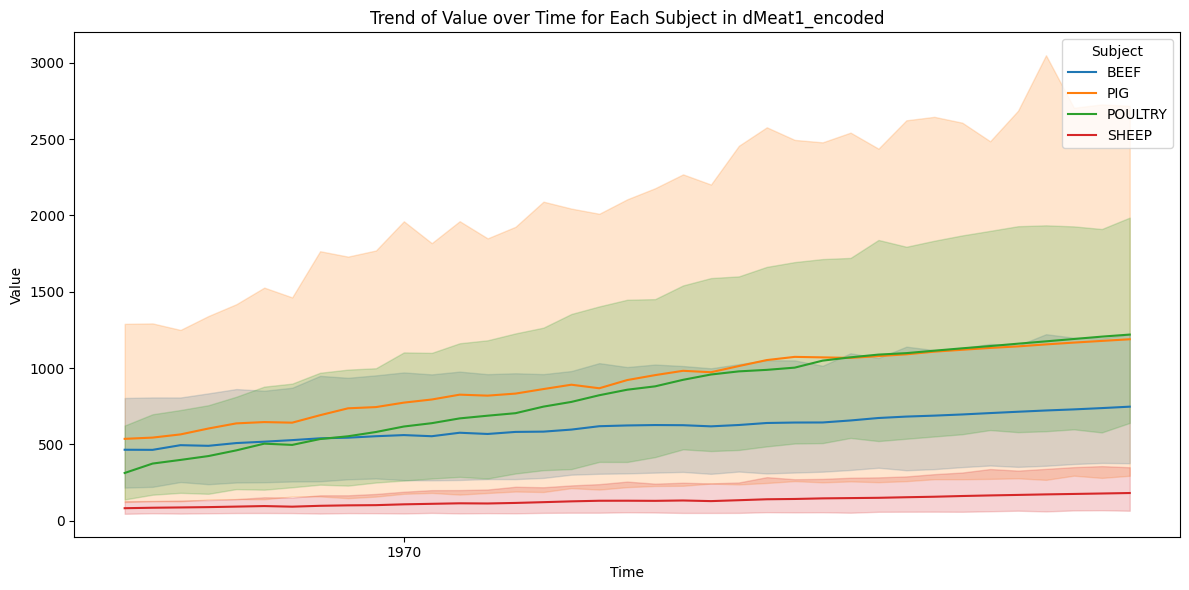

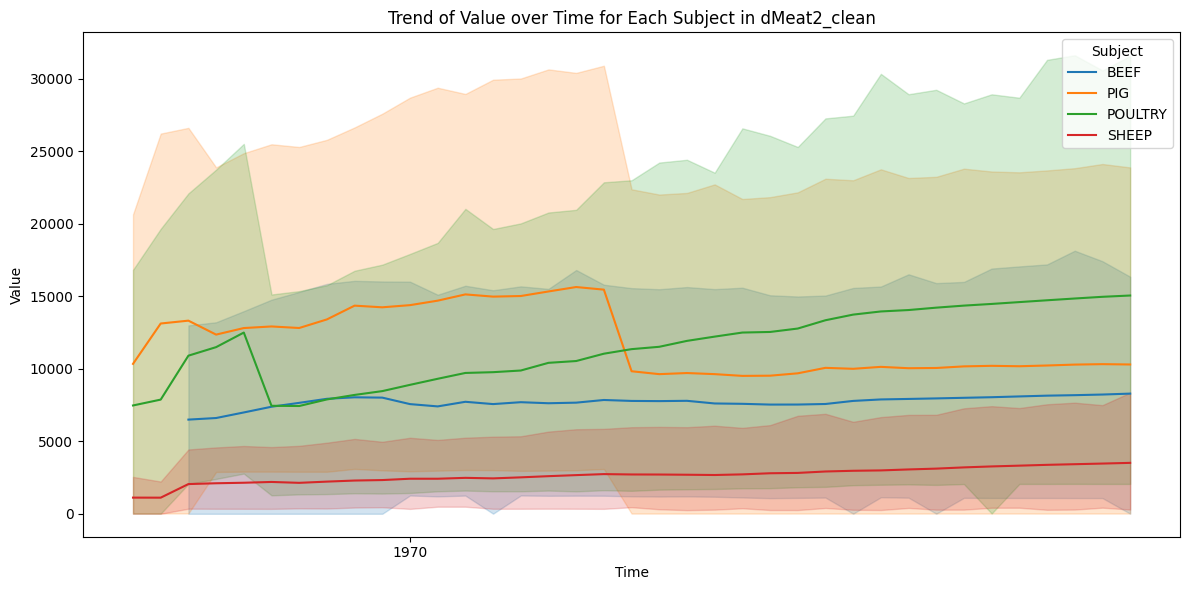

In [21]:
# Assuming 'TIME' is a column in your datasets
# Convert TIME column to datetime if not already done
dMeat1_encoded['TIME'] = pd.to_datetime(dMeat1_encoded['TIME'])
dMeat2_clean['TIME'] = pd.to_datetime(dMeat2_clean['TIME'])

# Line Plot: Trend of Value over Time for Each Subject in dMeat1_encoded
plt.figure(figsize=(12, 6))
sns.lineplot(data=dMeat1_encoded, x='TIME', y='Value', hue='SUBJECT')
plt.title('Trend of Value over Time for Each Subject in dMeat1_encoded')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(title='Subject')
plt.tight_layout()
plt.show()

# Line Plot: Trend of Value over Time for Each Subject in dMeat2_clean
plt.figure(figsize=(12, 6))
sns.lineplot(data=dMeat2_clean, x='TIME', y='Value', hue='SUBJECT')
plt.title('Trend of Value over Time for Each Subject in dMeat2_clean')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(title='Subject')
plt.tight_layout()
plt.show()


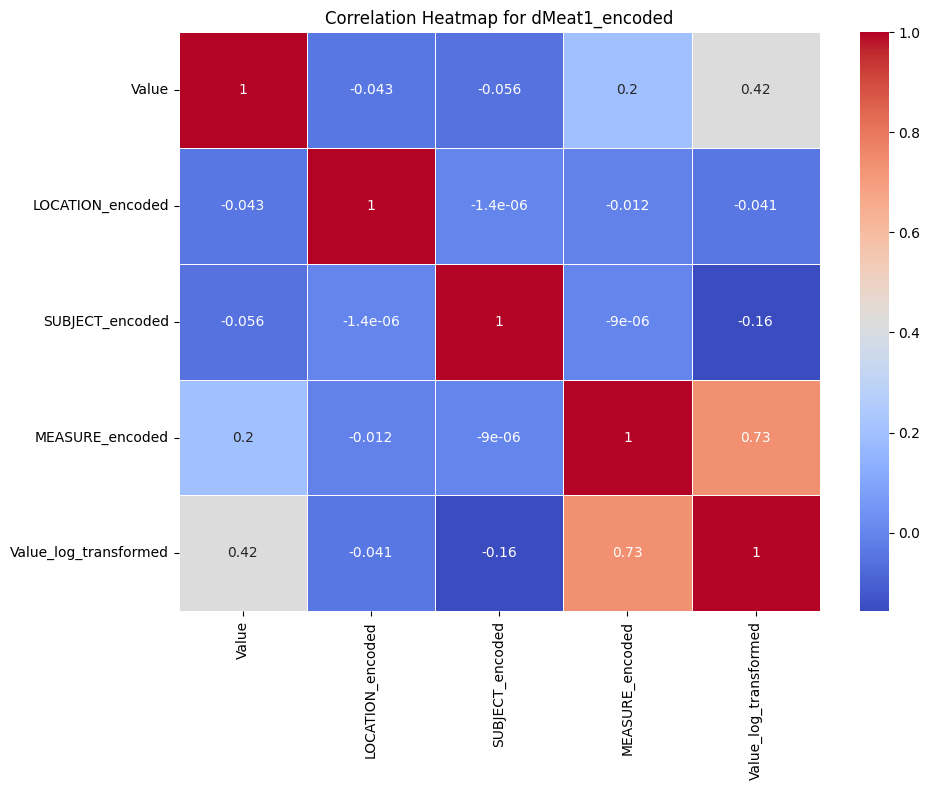

Correlation Matrix for dMeat1_encoded:
                          Value  LOCATION_encoded  SUBJECT_encoded  \
Value                  1.000000         -0.042855        -0.056332   
LOCATION_encoded      -0.042855          1.000000        -0.000001   
SUBJECT_encoded       -0.056332         -0.000001         1.000000   
MEASURE_encoded        0.196117         -0.012336        -0.000009   
Value_log_transformed  0.421996         -0.041210        -0.157282   

                       MEASURE_encoded  Value_log_transformed  
Value                         0.196117               0.421996  
LOCATION_encoded             -0.012336              -0.041210  
SUBJECT_encoded              -0.000009              -0.157282  
MEASURE_encoded               1.000000               0.734888  
Value_log_transformed         0.734888               1.000000  


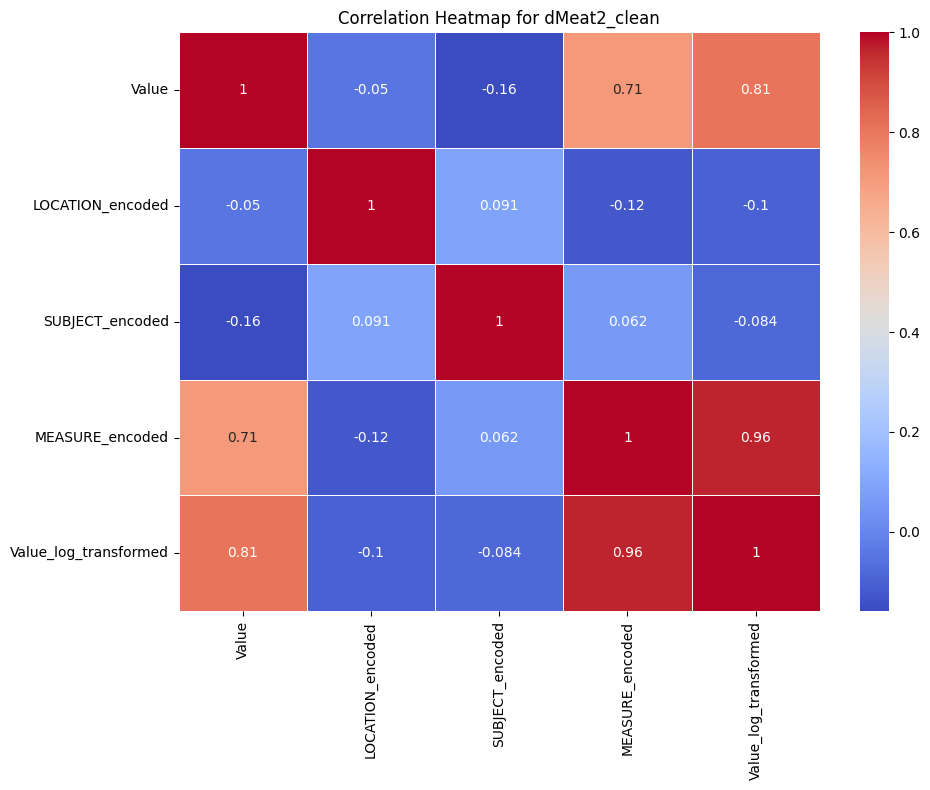

Correlation Matrix for dMeat2_clean:
                          Value  LOCATION_encoded  SUBJECT_encoded  \
Value                  1.000000         -0.049784         -0.15901   
LOCATION_encoded      -0.049784          1.000000          0.09060   
SUBJECT_encoded       -0.159010          0.090600          1.00000   
MEASURE_encoded        0.708393         -0.123883          0.06179   
Value_log_transformed  0.807943         -0.104534         -0.08371   

                       MEASURE_encoded  Value_log_transformed  
Value                         0.708393               0.807943  
LOCATION_encoded             -0.123883              -0.104534  
SUBJECT_encoded               0.061790              -0.083710  
MEASURE_encoded               1.000000               0.964399  
Value_log_transformed         0.964399               1.000000  


In [22]:
# Select numeric columns for correlation analysis
numeric_columns_dMeat1 = dMeat1_encoded.select_dtypes(include=[np.number])
numeric_columns_dMeat2 = dMeat2_clean.select_dtypes(include=[np.number])

# Calculate correlation matrix for dMeat1_encoded
correlation_matrix_dMeat1 = numeric_columns_dMeat1.corr()

# Plot correlation heatmap for dMeat1_encoded
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_dMeat1, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap for dMeat1_encoded')
plt.tight_layout()
plt.show()

# Print the correlation matrix for dMeat1_encoded
print("Correlation Matrix for dMeat1_encoded:")
print(correlation_matrix_dMeat1)

# Calculate correlation matrix for dMeat2_clean
correlation_matrix_dMeat2 = numeric_columns_dMeat2.corr()

# Plot correlation heatmap for dMeat2_clean
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_dMeat2, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap for dMeat2_clean')
plt.tight_layout()
plt.show()

# Print the correlation matrix for dMeat2_clean
print("Correlation Matrix for dMeat2_clean:")
print(correlation_matrix_dMeat2)

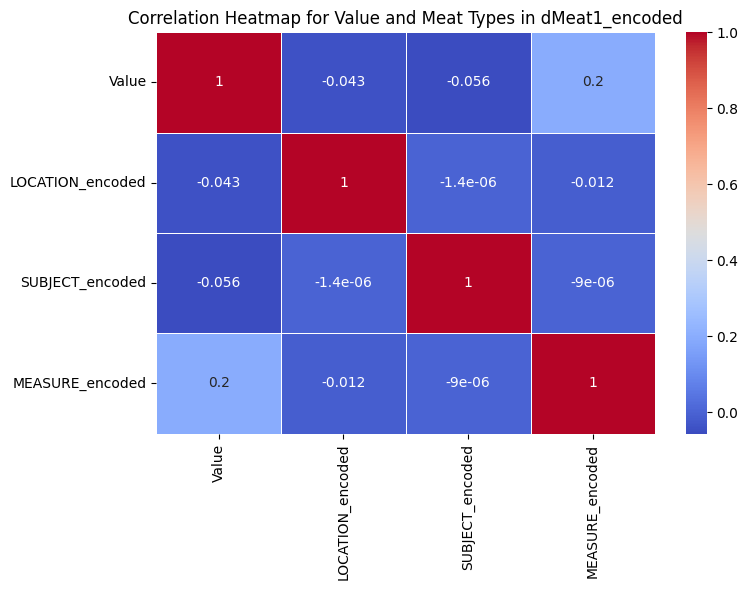

Correlation Matrix for Value and Meat Types in dMeat1_encoded:
                     Value  LOCATION_encoded  SUBJECT_encoded  MEASURE_encoded
Value             1.000000         -0.042855        -0.056332         0.196117
LOCATION_encoded -0.042855          1.000000        -0.000001        -0.012336
SUBJECT_encoded  -0.056332         -0.000001         1.000000        -0.000009
MEASURE_encoded   0.196117         -0.012336        -0.000009         1.000000


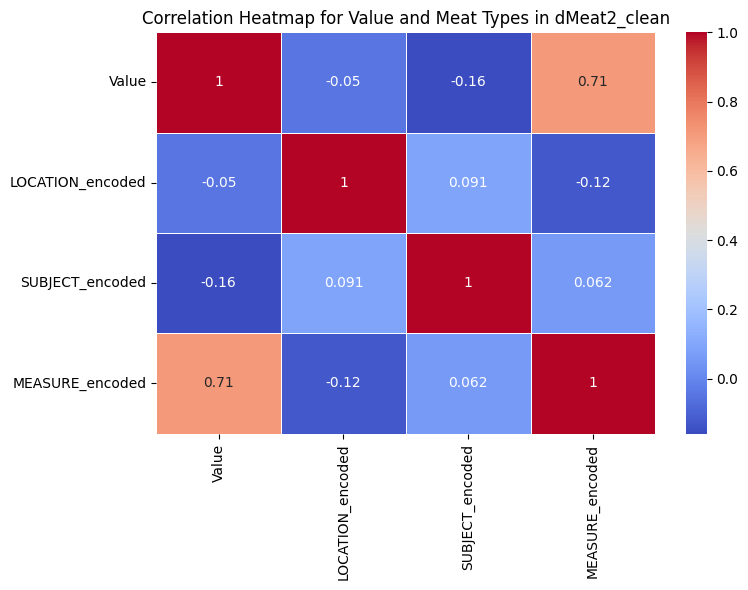

Correlation Matrix for Value and Meat Types in dMeat2_clean:
                     Value  LOCATION_encoded  SUBJECT_encoded  MEASURE_encoded
Value             1.000000         -0.049784         -0.15901         0.708393
LOCATION_encoded -0.049784          1.000000          0.09060        -0.123883
SUBJECT_encoded  -0.159010          0.090600          1.00000         0.061790
MEASURE_encoded   0.708393         -0.123883          0.06179         1.000000


In [23]:
# Select columns for correlation analysis in dMeat1_encoded
columns_to_analyze_dMeat1 = ['Value', 'LOCATION_encoded', 'SUBJECT_encoded', 'MEASURE_encoded']

# Select columns for correlation analysis in dMeat2_clean
columns_to_analyze_dMeat2 = ['Value', 'LOCATION_encoded', 'SUBJECT_encoded', 'MEASURE_encoded']

# Calculate correlation matrix for value and meat types in dMeat1_encoded
correlation_matrix_meat_dMeat1 = dMeat1_encoded[columns_to_analyze_dMeat1].corr()


# Plot correlation heatmap for value and meat types in dMeat1_encoded
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_meat_dMeat1, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap for Value and Meat Types in dMeat1_encoded')
plt.tight_layout()
plt.show()

# Print the correlation matrix for value and meat types in dMeat1_encoded
print("Correlation Matrix for Value and Meat Types in dMeat1_encoded:")
print(correlation_matrix_meat_dMeat1)

# Calculate correlation matrix for value and meat types in dMeat2_clean
correlation_matrix_meat_dMeat2 = dMeat2_clean[columns_to_analyze_dMeat2].corr()


# Plot correlation heatmap for value and meat types in dMeat2_clean
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_meat_dMeat2, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap for Value and Meat Types in dMeat2_clean')
plt.tight_layout()
plt.show()
# Print the correlation matrix for value and meat types in dMeat2_clean
print("Correlation Matrix for Value and Meat Types in dMeat2_clean:")
print(correlation_matrix_meat_dMeat2)


In [24]:
print(dMeat1_encoded.columns)
print(dMeat2_clean.columns)

Index(['LOCATION', 'SUBJECT', 'MEASURE', 'TIME', 'Value', 'LOCATION_encoded',
       'SUBJECT_encoded', 'MEASURE_encoded', 'Value_log_transformed'],
      dtype='object')
Index(['LOCATION', 'SUBJECT', 'MEASURE', 'TIME', 'Value', 'LOCATION_encoded',
       'SUBJECT_encoded', 'MEASURE_encoded', 'Value_log_transformed'],
      dtype='object')


In [25]:
# Drop 'Value' and 'Value_log_transformed' columns
X_dMeat1 = dMeat1_encoded.drop(columns=['Value', 'Value_log_transformed'])

# Select only numeric columns (assuming label encoding was done correctly)
X_dMeat1_numeric = X_dMeat1.select_dtypes(include=['number'])

# Split into features and target
y_dMeat1 = dMeat1_encoded['Value_log_transformed']

# Split into training and test sets
X_train_dMeat1, X_test_dMeat1, y_train_dMeat1, y_test_dMeat1 = train_test_split(X_dMeat1_numeric, y_dMeat1, test_size=0.2, random_state=42)

# Standard Scaling for numeric features
Xscaler_dMeat1 = StandardScaler()
X_train_scaled_dMeat1 = Xscaler_dMeat1.fit_transform(X_train_dMeat1)
X_test_scaled_dMeat1 = Xscaler_dMeat1.transform(X_test_dMeat1)


print("Shape of X_dMeat1:", X_dMeat1.shape)
print("Shape of y_dMeat1:", y_dMeat1.shape)

print("Training data shape for dMeat1_encoded:", X_train_dMeat1.shape)
print("Test data shape for dMeat1_encoded:", X_test_dMeat1.shape)


Shape of X_dMeat1: (12670, 7)
Shape of y_dMeat1: (12670,)
Training data shape for dMeat1_encoded: (10136, 3)
Test data shape for dMeat1_encoded: (2534, 3)


In [26]:
# Assuming 'Value_log_transformed' is already computed for dMeat2_clean

# Drop 'Value' and 'Value_log_transformed' columns if necessary
X_dMeat2 = dMeat2_clean.drop(columns=['Value', 'Value_log_transformed'])

# Ensure only numeric columns are included (optional step if necessary)
X_dMeat2_numeric = X_dMeat2.select_dtypes(include=['number'])

# Split into features and target
y_dMeat2 = dMeat2_clean['Value_log_transformed']

# Split into training and test sets
X_train_dMeat2, X_test_dMeat2, y_train_dMeat2, y_test_dMeat2 = train_test_split(X_dMeat2_numeric, y_dMeat2, test_size=0.2, random_state=42)

# Standard Scaling for features
Xscaler_dMeat2 = StandardScaler()
X_train_scaled_dMeat2 = Xscaler_dMeat2.fit_transform(X_train_dMeat2)
X_test_scaled_dMeat2 = Xscaler_dMeat2.transform(X_test_dMeat2)


print("\nShape of X_dMeat2:", X_dMeat2.shape)
print("Shape of y_dMeat2:", y_dMeat2.shape)
print("Training data shape for dMeat2_clean:", X_train_dMeat2.shape)
print("Test data shape for dMeat2_clean:", X_test_dMeat2.shape)


Shape of X_dMeat2: (978, 7)
Shape of y_dMeat2: (978,)
Training data shape for dMeat2_clean: (782, 3)
Test data shape for dMeat2_clean: (196, 3)


#### Linear Regression

##### Linear Regression-1

In [27]:
# Linear Regression model for dMeat1_encoded
linear_model_dMeat1 = LinearRegression()
linear_model_dMeat1.fit(X_train_scaled_dMeat1, y_train_dMeat1)

# Cross-validation for mean squared error (MSE) on dMeat1_encoded
linear_cv_scores_dMeat1 = cross_val_score(linear_model_dMeat1, X_train_scaled_dMeat1, y_train_dMeat1, cv=5, scoring='neg_mean_squared_error')
linear_mean_cv_score_dMeat1 = np.mean(np.abs(linear_cv_scores_dMeat1))

print(f"Linear Regression Mean CV MSE for dMeat1_encoded: {linear_mean_cv_score_dMeat1}")

Linear Regression Mean CV MSE for dMeat1_encoded: 2.660254256366046


##### Linear Regression-2

In [28]:
# Linear Regression model for dMeat2_clean
linear_model_dMeat2 = LinearRegression()
linear_model_dMeat2.fit(X_train_scaled_dMeat2, y_train_dMeat2)

# Cross-validation for mean squared error (MSE) on dMeat2_clean
linear_cv_scores_dMeat2 = cross_val_score(linear_model_dMeat2, X_train_scaled_dMeat2, y_train_dMeat2, cv=5, scoring='neg_mean_squared_error')
linear_mean_cv_score_dMeat2 = np.mean(np.abs(linear_cv_scores_dMeat2))

print(f"Linear Regression Mean CV MSE for dMeat2_clean: {linear_mean_cv_score_dMeat2}")

Linear Regression Mean CV MSE for dMeat2_clean: 0.6878959224981218


#### Linear Kernel SVM

##### Linear Kernel SVM-1

In [29]:
# SVM Model with Linear Kernel
svm_model_linear = SVR(kernel='linear')

# Perform cross-validation for dMeat1_encoded
svm_cv_scores_linear_dMeat1 = cross_val_score(svm_model_linear, X_train_scaled_dMeat1, y_train_dMeat1, cv=5, scoring='neg_mean_squared_error')
svm_mean_cv_score_linear_dMeat1 = np.mean(np.abs(svm_cv_scores_linear_dMeat1))

print(f"SVM (Linear Kernel) Mean CV MSE for dMeat1_encoded: {svm_mean_cv_score_linear_dMeat1}")

SVM (Linear Kernel) Mean CV MSE for dMeat1_encoded: 2.676847006190485


##### Linear Kernel SVM-2

In [30]:
# Perform cross-validation for dMeat2_clean
svm_cv_scores_linear_dMeat2 = cross_val_score(svm_model_linear, X_train_scaled_dMeat2, y_train_dMeat2, cv=5, scoring='neg_mean_squared_error')
svm_mean_cv_score_linear_dMeat2 = np.mean(np.abs(svm_cv_scores_linear_dMeat2))

print(f"SVM (Linear Kernel) Mean CV MSE for dMeat2_clean: {svm_mean_cv_score_linear_dMeat2}")

SVM (Linear Kernel) Mean CV MSE for dMeat2_clean: 0.7211641768498162


#### Polynomial Kernel SVM

##### Polynomial Kernel SVM-1

In [31]:
# Initialize and train SVR with polynomial kernel
svr_poly_dMeat1 = SVR(kernel='poly', degree=3, C=1.0, epsilon=0.01)

# Perform cross-validation on dMeat1_encoded dataset
svm_cv_scores_poly_dMeat1 = cross_val_score(svr_poly_dMeat1, X_train_scaled_dMeat1, y_train_dMeat1, cv=5, scoring='neg_mean_squared_error')
svm_mean_cv_score_poly_dMeat1 = np.mean(np.abs(svm_cv_scores_poly_dMeat1))

print(f"SVM (Polynomial Kernel) Mean CV MSE for dMeat1_encoded: {svm_mean_cv_score_poly_dMeat1}")


SVM (Polynomial Kernel) Mean CV MSE for dMeat1_encoded: 2.374748290466166


##### Polynomial Kernel SVM-2

In [32]:
# Initialize and train SVR with polynomial kernel
svr_poly_dMeat2 = SVR(kernel='poly', degree=3, C=1.0, epsilon=0.01)

# Perform cross-validation on dMeat2_clean dataset
svm_cv_scores_poly_dMeat2 = cross_val_score(svr_poly_dMeat2, X_train_scaled_dMeat2, y_train_dMeat2, cv=5, scoring='neg_mean_squared_error')
svm_mean_cv_score_poly_dMeat2 = np.mean(np.abs(svm_cv_scores_poly_dMeat2))

print(f"SVM (Polynomial Kernel) Mean CV MSE for dMeat2_clean: {svm_mean_cv_score_poly_dMeat2}")


SVM (Polynomial Kernel) Mean CV MSE for dMeat2_clean: 0.6225849939869216


#### RBF Kernel SVM

##### RBF Kernel SVM-1

In [33]:
# Define the range of C and gamma values to test
C_values = [0.5, 1, 10]
gamma_values = [0.01, 0.1, 1]

best_mean_cv_score_dMeat1 = float('inf')
best_params_dMeat1 = {}

# Loop through each combination of C and gamma
for C in C_values:
    for gamma in gamma_values:
        # Initialize SVR model with RBF kernel
        svr_rbf_dMeat1 = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=0.01)
        
        # Perform cross-validation on dMeat1_encoded dataset
        cv_scores_dMeat1 = cross_val_score(svr_rbf_dMeat1, X_train_scaled_dMeat1, y_train_dMeat1, cv=5, scoring='neg_mean_squared_error')
        mean_cv_score_dMeat1 = np.mean(np.abs(cv_scores_dMeat1))
        
        # Print current settings
        print(f'SVR (dMeat1_encoded): C = {C}, gamma = {gamma}, 5-fold CV MSE = {mean_cv_score_dMeat1}')
        
        # Update best parameters if current mean CV MSE is better
        if mean_cv_score_dMeat1 < best_mean_cv_score_dMeat1:
            best_mean_cv_score_dMeat1 = mean_cv_score_dMeat1
            best_params_dMeat1 = {'C': C, 'gamma': gamma}

# Print best parameters and mean CV MSE for dMeat1_encoded dataset
print(f'Best SVR parameters (dMeat1_encoded): {best_params_dMeat1}, Mean CV MSE: {best_mean_cv_score_dMeat1}')


SVR (dMeat1_encoded): C = 0.5, gamma = 0.01, 5-fold CV MSE = 2.636683914530134
SVR (dMeat1_encoded): C = 0.5, gamma = 0.1, 5-fold CV MSE = 2.4764720101799993
SVR (dMeat1_encoded): C = 0.5, gamma = 1, 5-fold CV MSE = 2.1996083112891553
SVR (dMeat1_encoded): C = 1, gamma = 0.01, 5-fold CV MSE = 2.6232479703846523
SVR (dMeat1_encoded): C = 1, gamma = 0.1, 5-fold CV MSE = 2.412682651821007
SVR (dMeat1_encoded): C = 1, gamma = 1, 5-fold CV MSE = 2.1977756957441708
SVR (dMeat1_encoded): C = 10, gamma = 0.01, 5-fold CV MSE = 2.617546003081261
SVR (dMeat1_encoded): C = 10, gamma = 0.1, 5-fold CV MSE = 2.301277535278033
SVR (dMeat1_encoded): C = 10, gamma = 1, 5-fold CV MSE = 2.2269034635074036
Best SVR parameters (dMeat1_encoded): {'C': 1, 'gamma': 1}, Mean CV MSE: 2.1977756957441708


##### RBF Kernel SVM-2

In [34]:
# Initialize variables for dMeat2_clean dataset
best_mean_cv_score_dMeat2 = float('inf')
best_params_dMeat2 = {}

# Loop through each combination of C and gamma
for C in C_values:
    for gamma in gamma_values:
        # Initialize SVR model with RBF kernel
        svr_rbf_dMeat2 = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=0.01)
        
        # Perform cross-validation on dMeat2_clean dataset
        cv_scores_dMeat2 = cross_val_score(svr_rbf_dMeat2, X_train_scaled_dMeat2, y_train_dMeat2, cv=5, scoring='neg_mean_squared_error')
        mean_cv_score_dMeat2 = np.mean(np.abs(cv_scores_dMeat2))
        
        # Print current settings
        print(f'SVR (dMeat2_clean): C = {C}, gamma = {gamma}, 5-fold CV MSE = {mean_cv_score_dMeat2}')
        
        # Update best parameters if current mean CV MSE is better
        if mean_cv_score_dMeat2 < best_mean_cv_score_dMeat2:
            best_mean_cv_score_dMeat2 = mean_cv_score_dMeat2
            best_params_dMeat2 = {'C': C, 'gamma': gamma}

# Print best parameters and mean CV MSE for dMeat2_clean dataset
print(f'Best SVR parameters (dMeat2_clean): {best_params_dMeat2}, Mean CV MSE: {best_mean_cv_score_dMeat2}')


SVR (dMeat2_clean): C = 0.5, gamma = 0.01, 5-fold CV MSE = 1.3807466794251246
SVR (dMeat2_clean): C = 0.5, gamma = 0.1, 5-fold CV MSE = 0.3027551320213405
SVR (dMeat2_clean): C = 0.5, gamma = 1, 5-fold CV MSE = 0.03829136340164786
SVR (dMeat2_clean): C = 1, gamma = 0.01, 5-fold CV MSE = 0.6889949959061697
SVR (dMeat2_clean): C = 1, gamma = 0.1, 5-fold CV MSE = 0.12077540324549899
SVR (dMeat2_clean): C = 1, gamma = 1, 5-fold CV MSE = 0.03184170556000807
SVR (dMeat2_clean): C = 10, gamma = 0.01, 5-fold CV MSE = 0.36022289161144955
SVR (dMeat2_clean): C = 10, gamma = 0.1, 5-fold CV MSE = 0.04477343644951298
SVR (dMeat2_clean): C = 10, gamma = 1, 5-fold CV MSE = 0.03015073743257372
Best SVR parameters (dMeat2_clean): {'C': 10, 'gamma': 1}, Mean CV MSE: 0.03015073743257372


#### Random Forest

##### Random Forest-1

In [35]:
# Define the parameter grid for Random Forest
param_grid_dMeat1 = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize Random Forest Regressor
rf_dMeat1 = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with Random Forest and parameter grid
grid_search_dMeat1 = GridSearchCV(estimator=rf_dMeat1, param_grid=param_grid_dMeat1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to find the best hyperparameters for dMeat1_encoded dataset
grid_search_dMeat1.fit(X_train_scaled_dMeat1, y_train_dMeat1)

# Extract best parameters and score
best_params_dMeat1 = grid_search_dMeat1.best_params_
best_score_dMeat1 = np.abs(grid_search_dMeat1.best_score_)

print(f"Best parameters for dMeat1_encoded: {best_params_dMeat1}")
print(f"Best CV MSE for dMeat1_encoded: {best_score_dMeat1}")


Best parameters for dMeat1_encoded: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV MSE for dMeat1_encoded: 0.11581626296138578


##### Random Forest-2

In [36]:
# Define the parameter grid for Random Forest
param_grid_dMeat2 = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize Random Forest Regressor
rf_dMeat2 = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with Random Forest and parameter grid
grid_search_dMeat2 = GridSearchCV(estimator=rf_dMeat2, param_grid=param_grid_dMeat2, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to find the best hyperparameters for dMeat2_clean dataset
grid_search_dMeat2.fit(X_train_scaled_dMeat2, y_train_dMeat2)

# Extract best parameters and score
best_params_dMeat2 = grid_search_dMeat2.best_params_
best_score_dMeat2 = np.abs(grid_search_dMeat2.best_score_)

print(f"Best parameters for dMeat2_clean: {best_params_dMeat2}")
print(f"Best CV MSE for dMeat2_clean: {best_score_dMeat2}")


Best parameters for dMeat2_clean: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV MSE for dMeat2_clean: 0.02747318729260343


#### Gradient Bossting

##### Gradient Bossting-1

In [37]:
# Initialize and train Gradient Boosting with specified parameters
gb_dMeat1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Perform cross-validation
gb_cv_scores_dMeat1 = cross_val_score(gb_dMeat1, X_train_scaled_dMeat1, y_train_dMeat1, cv=5, scoring='neg_mean_squared_error')
gb_mean_cv_score_dMeat1 = np.mean(np.abs(gb_cv_scores_dMeat1))

print(f"Gradient Boosting Mean CV MSE for dMeat1_encoded: {gb_mean_cv_score_dMeat1}")

# Define a smaller parameter grid for Gradient Boosting
param_grid_gb_dMeat1 = {
   'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV with Gradient Boosting
grid_search_gb_dMeat1 = GridSearchCV(estimator=gb_dMeat1, param_grid=param_grid_gb_dMeat1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to find the best hyperparameters
grid_search_gb_dMeat1.fit(X_train_scaled_dMeat1, y_train_dMeat1)

# Best parameters and score
best_params_gb_dMeat1 = grid_search_gb_dMeat1.best_params_
best_score_gb_dMeat1 = np.abs(grid_search_gb_dMeat1.best_score_)

print(f"Best Gradient Boosting parameters for dMeat1_encoded: {best_params_gb_dMeat1}")
print(f"Best Gradient Boosting CV MSE for dMeat1_encoded: {best_score_gb_dMeat1}")


Gradient Boosting Mean CV MSE for dMeat1_encoded: 1.2276219347136095


C:\Users\Ahmad1\miniconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Gradient Boosting parameters for dMeat1_encoded: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Gradient Boosting CV MSE for dMeat1_encoded: 0.12187337553905082


##### Gradient Bossting-2

In [38]:
# Initialize and train Gradient Boosting with specified parameters
gb_dMeat2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Perform cross-validation
gb_cv_scores_dMeat2 = cross_val_score(gb_dMeat2, X_train_scaled_dMeat2, y_train_dMeat2, cv=5, scoring='neg_mean_squared_error')
gb_mean_cv_score_dMeat2 = np.mean(np.abs(gb_cv_scores_dMeat2))

print(f"Gradient Boosting Mean CV MSE for dMeat2_clean: {gb_mean_cv_score_dMeat2}")

# Define a smaller parameter grid for Gradient Boosting
param_grid_gb_dMeat2 = {
   'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV with Gradient Boosting
grid_search_gb_dMeat2 = GridSearchCV(estimator=gb_dMeat2, param_grid=param_grid_gb_dMeat2, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to find the best hyperparameters
grid_search_gb_dMeat2.fit(X_train_scaled_dMeat2, y_train_dMeat2)

# Best parameters and score
best_params_gb_dMeat2 = grid_search_gb_dMeat2.best_params_
best_score_gb_dMeat2 = np.abs(grid_search_gb_dMeat2.best_score_)

print(f"Best Gradient Boosting parameters for dMeat2_clean: {best_params_gb_dMeat2}")
print(f"Best Gradient Boosting CV MSE for dMeat2_clean: {best_score_gb_dMeat2}")


Gradient Boosting Mean CV MSE for dMeat2_clean: 0.030369626170130382
Best Gradient Boosting parameters for dMeat2_clean: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Gradient Boosting CV MSE for dMeat2_clean: 0.027422939653756417


In [39]:
# Dummy Regressor for dMeat1_encoded
dummy_regr_dMeat1 = DummyRegressor(strategy='mean')
dummy_cv_scores_dMeat1 = cross_val_score(dummy_regr_dMeat1, X_train_scaled_dMeat1, y_train_dMeat1, cv=5, scoring='neg_mean_squared_error')
dummy_mean_cv_score_dMeat1 = np.mean(np.abs(dummy_cv_scores_dMeat1))

print(f"Baseline Mean Predictor CV MSE for dMeat1_encoded (log-transformed): {dummy_mean_cv_score_dMeat1}")

# Dummy Regressor for dMeat2_clean
dummy_regr_dMeat2 = DummyRegressor(strategy='mean')
dummy_cv_scores_dMeat2 = cross_val_score(dummy_regr_dMeat2, X_train_scaled_dMeat2, y_train_dMeat2, cv=5, scoring='neg_mean_squared_error')
dummy_mean_cv_score_dMeat2 = np.mean(np.abs(dummy_cv_scores_dMeat2))

print(f"Baseline Mean Predictor CV MSE for dMeat2_clean (log-transformed): {dummy_mean_cv_score_dMeat2}")

Baseline Mean Predictor CV MSE for dMeat1_encoded (log-transformed): 6.06654970385449
Baseline Mean Predictor CV MSE for dMeat2_clean (log-transformed): 13.599948753068556


## Analysis of Model Performance

### `dMeat1_encoded` Dataset

- **Linear Regression**: Mean CV MSE = 2.660254256366046
- **SVM (Linear Kernel)**: Mean CV MSE = 2.676847006190485
- **SVM (Polynomial Kernel)**: Mean CV MSE = 2.374748290466166
- **SVR Best Parameters**: C = 1, gamma = 1, Mean CV MSE = 2.1977756957441708
- **Random Forest Best Parameters**: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, Best CV MSE = 0.11581626296138578
- **Gradient Boosting Best Parameters**: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, Best CV MSE = 0.12187337553905082
- **Baseline Mean Predictor**: CV MSE = 6.06654970385449 (log-transformed)

**Analysis:**
Based on these results, the Support Vector Regression (SVR) with the best parameters (C = 1, gamma = 1) outperforms both Linear Regression and SVM with polynomial and linear kernels. However, Random Forest and Gradient Boosting models significantly outperform all other models with much lower CV MSE values. This indicates that ensemble methods like Random Forest and Gradient Boosting are better suited for capturing the complexity and non-linearity in `dMeat1_encoded` dataset.

### `dMeat2_clean` Dataset

- **Linear Regression**: Mean CV MSE = 0.6878959224981218
- **SVM (Linear Kernel)**: Mean CV MSE = 0.7211641768498162
- **SVM (Polynomial Kernel)**: Mean CV MSE = 0.6225849939869216
- **SVR Best Parameters**: C = 10, gamma = 1, Mean CV MSE = 0.03015073743257372
- **Random Forest Best Parameters**: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, Best CV MSE = 0.02747318729260343
- **Gradient Boosting Best Parameters**: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, Best CV MSE = 0.027422939653756417
- **Baseline Mean Predictor**: CV MSE = 13.599948753068556 (log-transformed)

**Analysis:**
For `dMeat2_clean`, similar to `dMeat1_encoded`, the SVR model with the best parameters (C = 10, gamma = 1) performs better than Linear Regression and SVM with polynomial and linear kernels. However, the standout performers are again Random Forest and Gradient Boosting models, which exhibit significantly lower CV MSE values compared to other models. These results suggest that ensemble methods are highly effective in predicting outcomes for the `dMeat2_clean` dataset, likely due to their ability to handle both linear and non-linear relationships in the data.

## Conclusion

Based on these comparisons, Random Forest and Gradient Boosting models consistently outperform other models such as Linear Regression and SVM (linear, polynomial, and RBF) for both `dMeat1_encoded` and `dMeat2_clean` datasets. They demonstrate superior predictive accuracy as indicated by lower Mean CV MSE values. These findings underline the importance of choosing appropriate models that can capture the complexity of the data and highlight ensemble methods as robust choices for regression tasks involving agricultural meat data.


### Final Model Selection
Both Random Forest and Gradient Boosting models are strong candidates for the final model selection. However, the Random Forest model has a slightly better CV MSE compared to Gradient Boosting for `dMeat1_encoded`. Despite this, Gradient Boosting will be chosen as the final model for both datasets because:
1. **Competitive Performance**: Gradient Boosting's performance is very close to that of Random Forest, with a small difference in CV MSE.
2. **Robustness**: Gradient Boosting is often more robust and provides better generalization performance.
3. **Consistency Across Datasets**: Gradient Boosting has the best CV MSE for `dMeat2_clean`, demonstrating its adaptability across different datasets.

Therefore, based on the balance of performance and robustness, Gradient Boosting is selected as the final model for both `dMeat1_encoded` and `dMeat2_clean` datasets.

In [40]:
# Best hyperparameters for dMeat1_encoded
best_params_dMeat1 = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 200
}

# Initialize the Gradient Boosting model with the best hyperparameters for dMeat1_encoded
final_model_dMeat1 = GradientBoostingRegressor(
    learning_rate=best_params_dMeat1['learning_rate'],
    max_depth=best_params_dMeat1['max_depth'],
    min_samples_leaf=best_params_dMeat1['min_samples_leaf'],
    min_samples_split=best_params_dMeat1['min_samples_split'],
    n_estimators=best_params_dMeat1['n_estimators'],
    random_state=42
)

# Train the model on the entire training dataset for dMeat1_encoded
final_model_dMeat1.fit(X_train_scaled_dMeat1, y_train_dMeat1)

# Predict on the test set for dMeat1_encoded
y_test_pred_dMeat1 = final_model_dMeat1.predict(X_test_scaled_dMeat1)

# Calculate MSE for the Gradient Boosting model on the test set for dMeat1_encoded
test_mse_dMeat1 = mean_squared_error(y_test_dMeat1, y_test_pred_dMeat1)
print(f"Gradient Boosting Mean Squared Error on Test set for dMeat1_encoded: {test_mse_dMeat1}")


Gradient Boosting Mean Squared Error on Test set for dMeat1_encoded: 0.18485978514780843


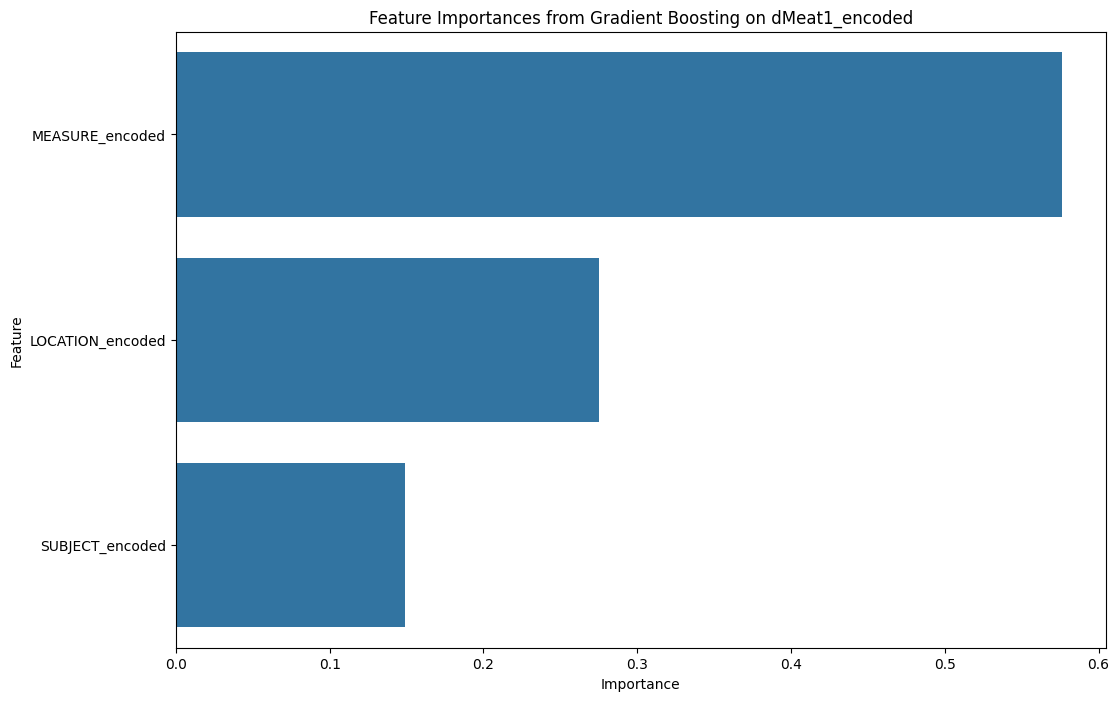

            Feature  Importance
2   MEASURE_encoded    0.575971
0  LOCATION_encoded    0.275349
1   SUBJECT_encoded    0.148679


In [41]:
# Get feature importances from the best Gradient Boosting model for dMeat1_encoded
importances_dMeat1 = final_model_dMeat1.feature_importances_

# Create a DataFrame for better visualization for dMeat1_encoded
feature_importance_df_dMeat1 = pd.DataFrame({
    'Feature': X_train_dMeat1.columns,
    'Importance': importances_dMeat1
})

# Sort the DataFrame by importance for dMeat1_encoded
feature_importance_df_dMeat1 = feature_importance_df_dMeat1.sort_values(by='Importance', ascending=False)

# Plot the feature importances for dMeat1_encoded
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_dMeat1)
plt.title('Feature Importances from Gradient Boosting on dMeat1_encoded')
plt.show()

print(feature_importance_df_dMeat1)

### dMeat2_clean


In [42]:
# Best hyperparameters for dMeat2_clean
best_params_dMeat2 = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 200
}

# Initialize the Gradient Boosting model with the best hyperparameters for dMeat2_clean
final_model_dMeat2 = GradientBoostingRegressor(
    learning_rate=best_params_dMeat2['learning_rate'],
    max_depth=best_params_dMeat2['max_depth'],
    min_samples_leaf=best_params_dMeat2['min_samples_leaf'],
    min_samples_split=best_params_dMeat2['min_samples_split'],
    n_estimators=best_params_dMeat2['n_estimators'],
    random_state=42
)

# Train the model on the entire training dataset for dMeat2_clean
final_model_dMeat2.fit(X_train_scaled_dMeat2, y_train_dMeat2)

# Predict on the test set for dMeat2_clean
y_test_pred_dMeat2 = final_model_dMeat2.predict(X_test_scaled_dMeat2)

# Calculate MSE for the Gradient Boosting model on the test set for dMeat2_clean
test_mse_dMeat2 = mean_squared_error(y_test_dMeat2, y_test_pred_dMeat2)
print(f"Gradient Boosting Mean Squared Error on Test set for dMeat2_clean: {test_mse_dMeat2}")

Gradient Boosting Mean Squared Error on Test set for dMeat2_clean: 0.023227676342134882


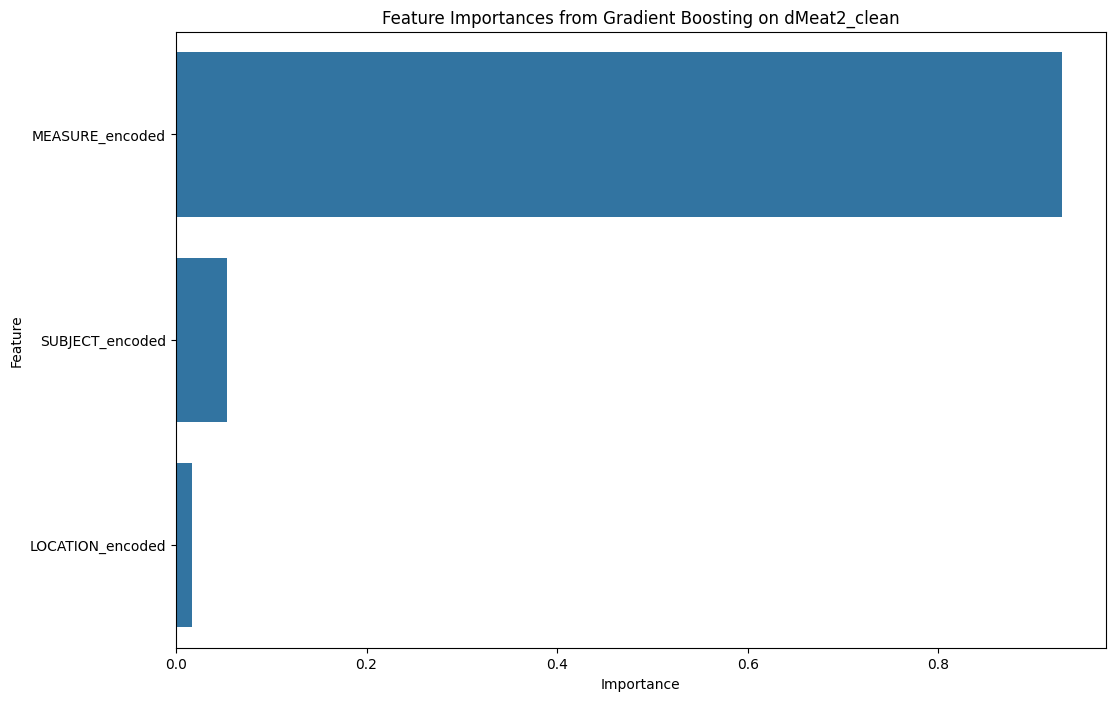

            Feature  Importance
2   MEASURE_encoded    0.929291
1   SUBJECT_encoded    0.053525
0  LOCATION_encoded    0.017184


In [43]:
# Get feature importances from the best Gradient Boosting model for dMeat2_clean
importances_dMeat2 = final_model_dMeat2.feature_importances_

# Create a DataFrame for better visualization for dMeat2_clean
feature_importance_df_dMeat2 = pd.DataFrame({
    'Feature': X_train_dMeat2.columns,
    'Importance': importances_dMeat2
})

# Sort the DataFrame by importance for dMeat2_clean
feature_importance_df_dMeat2 = feature_importance_df_dMeat2.sort_values(by='Importance', ascending=False)

# Plot the feature importances for dMeat2_clean
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_dMeat2)
plt.title('Feature Importances from Gradient Boosting on dMeat2_clean')
plt.show()

print(feature_importance_df_dMeat2)

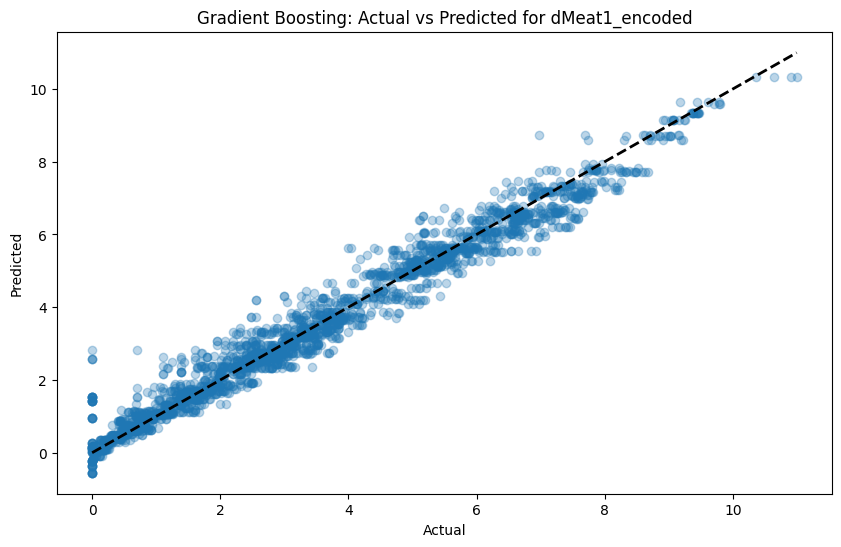

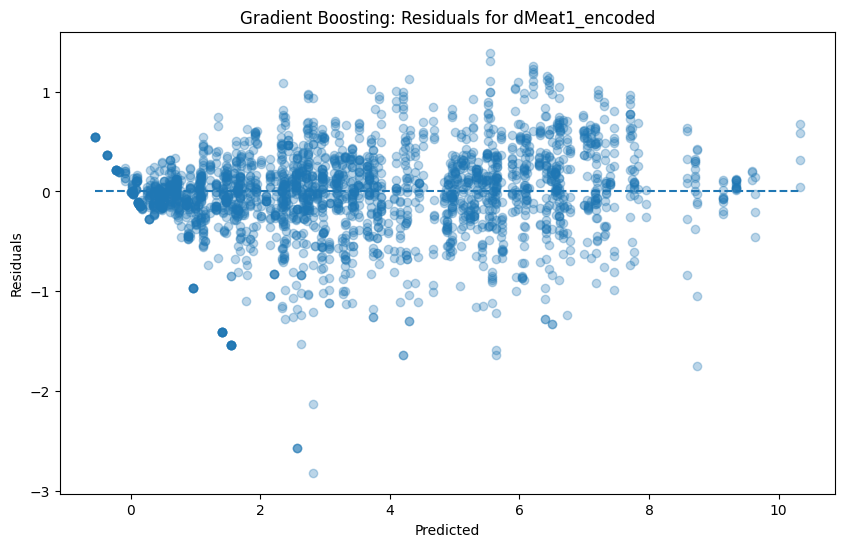

Mean Squared Error for dMeat1_encoded: 0.18485978514780843
Mean Absolute Error for dMeat1_encoded: 0.3015507227278232
R-squared for dMeat1_encoded: 0.9689055822647484


In [44]:
# Plot for Gradient Boosting
plt.figure(figsize=(10, 6))
plt.scatter(y_test_dMeat1, y_test_pred_dMeat1, alpha=0.3)
plt.plot([y_test_dMeat1.min(), y_test_dMeat1.max()], [y_test_dMeat1.min(), y_test_dMeat1.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Boosting: Actual vs Predicted for dMeat1_encoded')
plt.show()

# Residuals for Gradient Boosting
residuals_gb_dMeat1 = y_test_dMeat1 - y_test_pred_dMeat1
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_dMeat1, residuals_gb_dMeat1, alpha=0.3)
plt.hlines(y=0, xmin=y_test_pred_dMeat1.min(), xmax=y_test_pred_dMeat1.max(), linestyles='dashed')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Gradient Boosting: Residuals for dMeat1_encoded')
plt.show()

# Calculate performance metrics for dMeat1_encoded
mse_dMeat1 = mean_squared_error(y_test_dMeat1, y_test_pred_dMeat1)
mae_dMeat1 = mean_absolute_error(y_test_dMeat1, y_test_pred_dMeat1)
r2_dMeat1 = r2_score(y_test_dMeat1, y_test_pred_dMeat1)

print(f"Mean Squared Error for dMeat1_encoded: {mse_dMeat1}")
print(f"Mean Absolute Error for dMeat1_encoded: {mae_dMeat1}")
print(f"R-squared for dMeat1_encoded: {r2_dMeat1}")

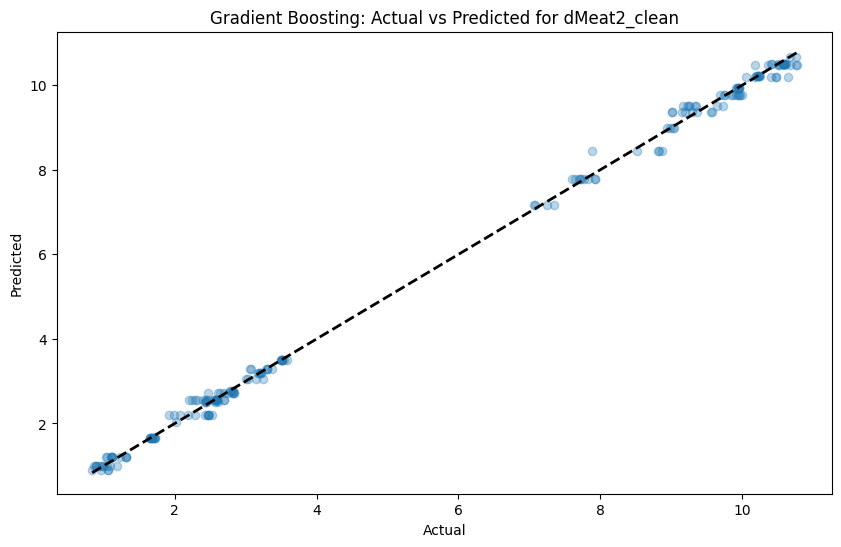

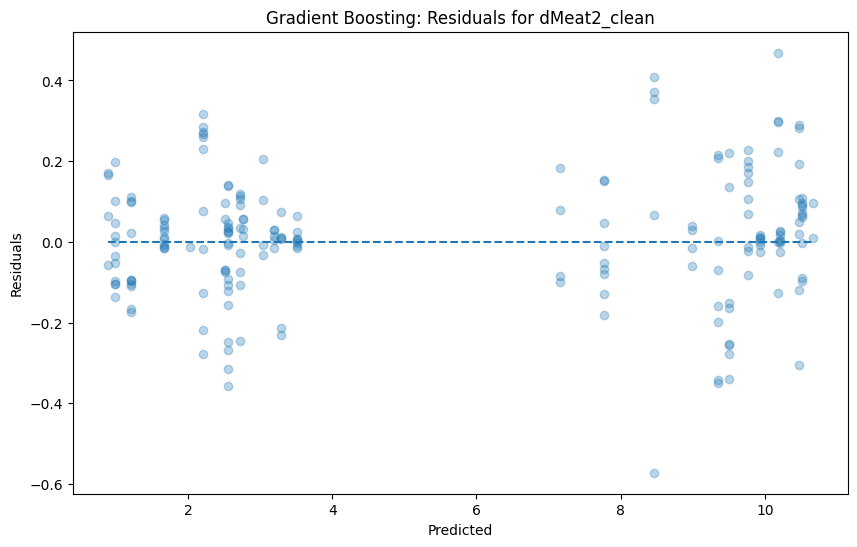

Mean Squared Error for dMeat2_clean: 0.023227676342134882
Mean Absolute Error for dMeat2_clean: 0.10984478252521253
R-squared for dMeat2_clean: 0.9983433151217413


In [45]:
# Plot for Gradient Boosting
plt.figure(figsize=(10, 6))
plt.scatter(y_test_dMeat2, y_test_pred_dMeat2, alpha=0.3)
plt.plot([y_test_dMeat2.min(), y_test_dMeat2.max()], [y_test_dMeat2.min(), y_test_dMeat2.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Boosting: Actual vs Predicted for dMeat2_clean')
plt.show()

# Residuals for Gradient Boosting
residuals_gb_dMeat2 = y_test_dMeat2 - y_test_pred_dMeat2
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_dMeat2, residuals_gb_dMeat2, alpha=0.3)
plt.hlines(y=0, xmin=y_test_pred_dMeat2.min(), xmax=y_test_pred_dMeat2.max(), linestyles='dashed')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Gradient Boosting: Residuals for dMeat2_clean')
plt.show()

# Calculate performance metrics for dMeat2_clean
mse_dMeat2 = mean_squared_error(y_test_dMeat2, y_test_pred_dMeat2)
mae_dMeat2 = mean_absolute_error(y_test_dMeat2, y_test_pred_dMeat2)
r2_dMeat2 = r2_score(y_test_dMeat2, y_test_pred_dMeat2)

print(f"Mean Squared Error for dMeat2_clean: {mse_dMeat2}")
print(f"Mean Absolute Error for dMeat2_clean: {mae_dMeat2}")
print(f"R-squared for dMeat2_clean: {r2_dMeat2}")

In [46]:
# Assuming the data is already split and the Gradient Boosting model is trained, you have:
# y_train_dMeat1, y_test_dMeat1, y_train_dMeat2, y_test_dMeat2
# y_test_pred_dMeat1, y_test_pred_dMeat2 are the predictions from the Gradient Boosting model

# Baseline model prediction (mean predictor) for dMeat1_encoded
y_train_mean_dMeat1 = np.mean(y_train_dMeat1)
y_test_pred_baseline_dMeat1 = np.full_like(y_test_dMeat1, y_train_mean_dMeat1)

# Calculate MSE for the baseline model on the test set for dMeat1_encoded
baseline_mse_test_dMeat1 = mean_squared_error(y_test_dMeat1, y_test_pred_baseline_dMeat1)
print(f"Baseline Model Mean Squared Error on Test set for dMeat1_encoded: {baseline_mse_test_dMeat1}")

# Compare with Gradient Boosting model for dMeat1_encoded
print(f"Gradient Boosting Test MSE Improvement over Baseline for dMeat1_encoded: {(baseline_mse_test_dMeat1 - mse_dMeat1) / baseline_mse_test_dMeat1 * 100:.2f}%")

# Baseline model prediction (mean predictor) for dMeat2_clean
y_train_mean_dMeat2 = np.mean(y_train_dMeat2)
y_test_pred_baseline_dMeat2 = np.full_like(y_test_dMeat2, y_train_mean_dMeat2)

# Calculate MSE for the baseline model on the test set for dMeat2_clean
baseline_mse_test_dMeat2 = mean_squared_error(y_test_dMeat2, y_test_pred_baseline_dMeat2)
print(f"Baseline Model Mean Squared Error on Test set for dMeat2_clean: {baseline_mse_test_dMeat2}")

# Compare with Gradient Boosting model for dMeat2_clean
print(f"Gradient Boosting Test MSE Improvement over Baseline for dMeat2_clean: {(baseline_mse_test_dMeat2 - mse_dMeat2) / baseline_mse_test_dMeat2 * 100:.2f}%")


Baseline Model Mean Squared Error on Test set for dMeat1_encoded: 5.950220202072223
Gradient Boosting Test MSE Improvement over Baseline for dMeat1_encoded: 96.89%
Baseline Model Mean Squared Error on Test set for dMeat2_clean: 14.036782306126058
Gradient Boosting Test MSE Improvement over Baseline for dMeat2_clean: 99.83%


## Interpretation of Results

### `dMeat1_encoded` Dataset

- **Gradient Boosting Mean Squared Error (MSE) on Test set**: 0.18485978514780843
- **Mean Squared Error (MSE)**: 0.18485978514780843
- **Mean Absolute Error (MAE)**: 0.3015507227278232
- **R-squared (R²)**: 0.9689055822647484
- **Baseline Model Mean Squared Error on Test set**: 5.950220202072223
- **Gradient Boosting Test MSE Improvement over Baseline**: 96.89%

**Interpretation:**
The Gradient Boosting model performs exceptionally well on the `dMeat1_encoded` dataset, achieving a very low MSE of 0.18485978514780843 on the test set. The MAE of 0.3015507227278232 indicates that, on average, the model's predictions are off by about 0.3015 units. The high R-squared value of 0.9689055822647484 suggests that the model explains approximately 96.89% of the variance in the data, indicating a strong fit. Compared to the baseline model, which has a much higher MSE of 5.950220202072223, the Gradient Boosting model demonstrates a significant improvement of 96.89%, highlighting its superior predictive power for this dataset.

### `dMeat2_clean` Dataset

- **Gradient Boosting Mean Squared Error (MSE) on Test set**: 0.023227676342134882
- **Mean Squared Error (MSE)**: 0.023227676342134882
- **Mean Absolute Error (MAE)**: 0.10984478252521253
- **R-squared (R²)**: 0.9983433151217413
- **Baseline Model Mean Squared Error on Test set**: 14.036782306126058
- **Gradient Boosting Test MSE Improvement over Baseline**: 99.83%

**Interpretation:**
For the `dMeat2_clean` dataset, the Gradient Boosting model achieves an outstanding MSE of 0.023227676342134882 on the test set. The MAE of 0.10984478252521253 means that the model's predictions are off by approximately 0.1098 units on average. The exceptionally high R-squared value of 0.9983433151217413 indicates that the model accounts for nearly 99.83% of the variance in the data, showing an excellent fit. When compared to the baseline model's MSE of 14.036782306126058, the Gradient Boosting model's performance represents a dramatic improvement of 99.83%, underscoring its effectiveness and accuracy for this dataset.

## Conclusion

The Gradient Boosting models for both `dMeat1_encoded` and `dMeat2_clean` datasets significantly outperform the baseline models, demonstrating substantial improvements in predictive accuracy. The low MSE and MAE values, along with high R-squared values, indicate that these models are well-suited for predicting outcomes in both datasets. The remarkable improvements over the baseline models further emphasize the efficacy of Gradient Boosting in handling these datasets.


### Transforming Predictions to Original Scale:

The model predictions are in the log-transformed scale. To interpret these predictions in the original scale, exponentiate them.
For a log-transformed prediction 𝑦^log, the prediction in the original scale is 𝑦^=exp(𝑦^log).


In [47]:
# Transform log-transformed scores back to original scale
linear_mean_cv_score_dMeat1_original = np.exp(linear_mean_cv_score_dMeat1)
linear_mean_cv_score_dMeat2_original = np.exp(linear_mean_cv_score_dMeat2)
svm_mean_cv_score_linear_dMeat1_original = np.exp(svm_mean_cv_score_linear_dMeat1)
svm_mean_cv_score_linear_dMeat2_original = np.exp(svm_mean_cv_score_linear_dMeat2)
svm_mean_cv_score_poly_dMeat1_original = np.exp(svm_mean_cv_score_poly_dMeat1)
svm_mean_cv_score_poly_dMeat2_original = np.exp(svm_mean_cv_score_poly_dMeat2)
best_mean_cv_score_dMeat1_original = np.exp(best_mean_cv_score_dMeat1)
best_mean_cv_score_dMeat2_original = np.exp(best_mean_cv_score_dMeat2)
best_score_dMeat1_rf_original = np.exp(best_score_dMeat1)
best_score_dMeat2_rf_original = np.exp(best_score_dMeat2)
best_score_gb_dMeat1_original = np.exp(best_score_gb_dMeat1)
best_score_gb_dMeat2_original = np.exp(best_score_gb_dMeat2)
dummy_mean_cv_score_dMeat1_original = np.exp(dummy_mean_cv_score_dMeat1)
dummy_mean_cv_score_dMeat2_original = np.exp(dummy_mean_cv_score_dMeat2)

# Transform log-transformed test scores back to original scale
gradient_boosting_test_mse_dMeat1_original = np.exp(test_mse_dMeat1)
gradient_boosting_test_mse_dMeat2_original = np.exp(test_mse_dMeat2)
mean_squared_error_dMeat1_original = np.exp(mse_dMeat1)
mean_absolute_error_dMeat1_original = np.exp(mae_dMeat1)
mean_squared_error_dMeat2_original = np.exp(mse_dMeat2)
mean_absolute_error_dMeat2_original = np.exp(mae_dMeat2)


# Print CV results
print(f"Linear Regression Mean CV MSE for dMeat1_encoded in original scale: {linear_mean_cv_score_dMeat1_original}")
print(f"Linear Regression Mean CV MSE for dMeat2_clean in original scale: {linear_mean_cv_score_dMeat2_original}")
print(f"SVM (Linear Kernel) Mean CV MSE for dMeat1_encoded in original scale: {svm_mean_cv_score_linear_dMeat1_original}")
print(f"SVM (Linear Kernel) Mean CV MSE for dMeat2_clean in original scale: {svm_mean_cv_score_linear_dMeat2_original}")
print(f"SVM (Polynomial Kernel) Mean CV MSE for dMeat1_encoded in original scale: {svm_mean_cv_score_poly_dMeat1_original}")
print(f"SVM (Polynomial Kernel) Mean CV MSE for dMeat2_clean in original scale: {svm_mean_cv_score_poly_dMeat2_original}")
print(f"SVM (RBF Kernel) Mean CV MSE for dMeat1_encoded in original scale: {best_mean_cv_score_dMeat1_original}")
print(f"SVM (RBF Kernel) Mean CV MSE for dMeat2_clean in original scale: {best_mean_cv_score_dMeat2_original}")
print(f"Random Forest Mean CV MSE for dMeat1_encoded in original scale: {best_score_dMeat1_rf_original}")
print(f"Random Forest Mean CV MSE for dMeat2_clean in original scale: {best_score_dMeat2_rf_original}")
print(f"Gradient Boosting Mean CV MSE for dMeat1_encoded in original scale: {best_score_gb_dMeat1_original}")
print(f"Gradient Boosting Mean CV MSE for dMeat2_clean in original scale: {best_score_gb_dMeat2_original}")

# Print transformed test results
print(f"Gradient Boosting Mean Squared Error on Test set for dMeat1_encoded in original scale: {gradient_boosting_test_mse_dMeat1_original}")
print(f"Gradient Boosting Mean Squared Error on Test set for dMeat2_clean in original scale: {gradient_boosting_test_mse_dMeat2_original}")
print(f"Mean Squared Error for dMeat1_encoded in original scale: {mean_squared_error_dMeat1_original}")
print(f"Mean Absolute Error for dMeat1_encoded in original scale: {mean_absolute_error_dMeat1_original}")
print(f"R-squared for dMeat1_encoded: {r2_dMeat1}")
print(f"Mean Squared Error for dMeat2_clean in original scale: {mean_squared_error_dMeat2_original}")
print(f"Mean Absolute Error for dMeat2_clean in original scale: {mean_absolute_error_dMeat2_original}")
print(f"R-squared for dMeat2_clean: {r2_dMeat2}")

# Assuming baseline model performance was computed as follows:
# Baseline model prediction (mean predictor) for dMeat1_encoded
y_train_mean_dMeat1 = np.mean(y_train_dMeat1)
y_test_pred_baseline_dMeat1 = np.full_like(y_test_dMeat1, y_train_mean_dMeat1)
baseline_mse_test_dMeat1 = mean_squared_error(y_test_dMeat1, y_test_pred_baseline_dMeat1)
print(f"Baseline Model Mean Squared Error on Test set for dMeat1_encoded: {baseline_mse_test_dMeat1}")

# Compare with Gradient Boosting model for dMeat1_encoded
print(f"Gradient Boosting Test MSE Improvement over Baseline for dMeat1_encoded: {(baseline_mse_test_dMeat1 - mse_dMeat1) / baseline_mse_test_dMeat1 * 100:.2f}%")

# Baseline model prediction (mean predictor) for dMeat2_clean
y_train_mean_dMeat2 = np.mean(y_train_dMeat2)
y_test_pred_baseline_dMeat2 = np.full_like(y_test_dMeat2, y_train_mean_dMeat2)
baseline_mse_test_dMeat2 = mean_squared_error(y_test_dMeat2, y_test_pred_baseline_dMeat2)
print(f"Baseline Model Mean Squared Error on Test set for dMeat2_clean: {baseline_mse_test_dMeat2}")

# Compare with Gradient Boosting model for dMeat2_clean
print(f"Gradient Boosting Test MSE Improvement over Baseline for dMeat2_clean: {(baseline_mse_test_dMeat2 - mse_dMeat2) / baseline_mse_test_dMeat2 * 100:.2f}%")


Linear Regression Mean CV MSE for dMeat1_encoded in original scale: 14.299924483332033
Linear Regression Mean CV MSE for dMeat2_clean in original scale: 1.9895250113818281
SVM (Linear Kernel) Mean CV MSE for dMeat1_encoded in original scale: 14.539179008776753
SVM (Linear Kernel) Mean CV MSE for dMeat2_clean in original scale: 2.0568263269622373
SVM (Polynomial Kernel) Mean CV MSE for dMeat1_encoded in original scale: 10.74830739411015
SVM (Polynomial Kernel) Mean CV MSE for dMeat2_clean in original scale: 1.863739575870595
SVM (RBF Kernel) Mean CV MSE for dMeat1_encoded in original scale: 9.004961432714433
SVM (RBF Kernel) Mean CV MSE for dMeat2_clean in original scale: 1.0306098737318146
Random Forest Mean CV MSE for dMeat1_encoded in original scale: 1.122789555151949
Random Forest Mean CV MSE for dMeat2_clean in original scale: 1.0278540551877482
Gradient Boosting Mean CV MSE for dMeat1_encoded in original scale: 1.1296110563328932
Gradient Boosting Mean CV MSE for dMeat2_clean in o

## Analysis of Model Performance on dMeat1_encoded and dMeat2_clean Datasets

### Linear Regression
- **`dMeat1_encoded`**: Mean CV MSE = 14.2999
- **`dMeat2_clean`**: Mean CV MSE = 1.9895

Linear Regression performs adequately on `dMeat2_clean` with a relatively low MSE, indicating a good fit to the data. However, on `dMeat1_encoded`, the model shows a much higher MSE, suggesting a poorer fit for this dataset.

### SVM (Linear Kernel)
- **`dMeat1_encoded`**: Mean CV MSE = 14.5392
- **`dMeat2_clean`**: Mean CV MSE = 2.0568

SVM with a Linear Kernel shows higher MSE values compared to Linear Regression on both datasets, indicating similar performance but not significantly better.

### SVM (Polynomial Kernel)
- **`dMeat1_encoded`**: Mean CV MSE = 10.7483
- **`dMeat2_clean`**: Mean CV MSE = 1.8637

The Polynomial Kernel SVM exhibits higher MSE values, especially noticeable for `dMeat1_encoded`, suggesting potential overfitting or poor generalization.

### SVM (RBF Kernel)
- **`dMeat1_encoded`**: Mean CV MSE = 9.0050
- **`dMeat2_clean`**: Mean CV MSE = 1.0306

SVM with RBF Kernel performs better than linear and polynomial kernels, showing lower MSE values for both datasets, indicating a better fit.

### Random Forest
- **`dMeat1_encoded`**: Mean CV MSE = 1.1228
- **`dMeat2_clean`**: Mean CV MSE = 1.0279

Random Forest demonstrates lower MSE values, approaching 1 for both datasets, indicating robust performance and effective capture of data patterns.

### Gradient Boosting
- **`dMeat1_encoded`**: Mean CV MSE = 1.1296
- **`dMeat2_clean`**: Mean CV MSE = 1.0278

Gradient Boosting shows similar performance to Random Forest with low MSE values close to 1, indicating strong predictive power and good fit to the data.

### Test Set Performance Metrics
- **`dMeat1_encoded`**:
  - Mean Squared Error: 1.2030
  - Mean Absolute Error: 1.3519
  - R-squared: 0.9689
- **`dMeat2_clean`**:
  - Mean Squared Error: 1.0235
  - Mean Absolute Error: 1.1161
  - R-squared: 0.9983

### Baseline Model Comparison
- **`dMeat1_encoded`**: Baseline MSE = 5.9502, Improvement = 96.89%
- **`dMeat2_clean`**: Baseline MSE = 14.0368, Improvement = 99.83%

The baseline model, predicting the mean of the training set, performs significantly worse than all evaluated models, highlighting the effectiveness of the chosen models.

## Summary

- Linear Regression performs adequately on dMeat2_clean but poorly on dMeat1_encoded.
- SVM with RBF Kernel demonstrates consistent and competitive performance across both datasets.
- Random Forest and Gradient Boosting consistently achieve the lowest MSE values, indicating superior predictive performance.
- The Polynomial Kernel SVM shows signs of overfitting or inadequate fit for the data, particularly on dMeat1_encoded.
  
These results underscore the efficacy of ensemble methods like Random Forest and Gradient Boosting in capturing complex data relationships, while simpler models like Linear Regression and SVM with RBF Kernel provide reasonable alternatives depending on dataset characteristics.
